In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
import itertools
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
register_matplotlib_converters()

In [3]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Software\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [4]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Cargo Value USD'] % unit_price < 2:
        return 1
      else:
        return row['Cargo Value USD'] // unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length(list_em,em):
    count  = 0
    for i in list_em:
        if i == em:
            count+=1
    return count

In [5]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [6]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [7]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [8]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [9]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [10]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [11]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [12]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [13]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [14]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-14-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-14-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [15]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-15-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-15-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [16]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-16-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-16-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [17]:
df_mitsubishi_GTO_extracted_em

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,brand,extracted_engine
12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",ИП КАРПЕНОК НАТАЛЬЯ ГЕННАДЬЕВНА,"690105, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. Р...",22,ШТ,FOB,5500.0,5500.0,3339.77,MITSUBISHI,[4G93]
22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD","614-8051 КЙОТО ЯВАТА-СИТИ ЯВАТА-ЯМАДА, 67-3",КАРПЕНОК НАТАЛЬЯ ГЕНАДЬЕВНА ПАСПОРТ 0503№28165...,"690105, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, РУССКАЯ ...",19,ШТ,FOB,4750.0,4750.0,2867.72,MITSUBISHI,"[6G73, 6G73]"
45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,"HIROSHIMA TAKAYADAI 2-CHOME, 1-8",ООО РДС-АВТО,"690066, ПРИМОРСКИЙ КРАЙ, ВЛАДИВОСТОК, УЛ.ШИЛКИ...",35,ШТ,CFR,10255.0,10255.0,6160.00,MITSUBISHI,[4G93]
55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD","KYOTO YAWATA-CITY 27, YAWATAKUBOTA",САКУРА МОТОРС КЕМЕРОВО ООО,"650010, КЕМЕРОВСКАЯ ОБЛАСТЬ, КЕМЕРОВО, МАЯКОВС...",34,ШТ,CFR,7235.0,7235.0,3945.00,MITSUBISHI,[4G93]
91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД","17-1 ДЖАПАН ПУСАН НИШИДЕГУЧИ,АЗА 16 ХАСУГАУРА,...",ООО ДВ-МОТОРС,"690065, ПРИМОРСКИЙ КРАЙ, Г. ВЛАДИВОСТОК, УЛ. С...",3,ШТ,CFR,600.0,600.0,480.00,MITSUBISHI,[4G15]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,MITSUBISHI,"[4G93, 4G94]"
259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,"ЯПОНИЯ, ЙОКОГАМА, АСОНА, БИЗИН 926-3",ИП МАТВЕЕВ СТАНИСЛАВ ВАЛЕРЬЕВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,467.0,467.0,706.00,MITSUBISHI,[4G93]
259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,"KIYOSE-CITY, TOKYO, 6-95-1-105 NAKAZATO",ИП ФОМИЧЕВ АЛЕКСАНДР ИВАНОВИЧ,"630000, ГОРОД НОВОСИБИРСК",0,unknown,CFR,460.0,460.0,720.70,MITSUBISHI,"[4G93, 4G63]"
259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),"1-62, FUKUOKA, KITAKYUSHU, HIBIKIMACHI, WAKAMA...",ООО ПАРУС,"650040, 650040, ОБЛАСТЬ КЕМЕРОВСКАЯ ОБЛАСТЬ - ...",0,unknown,CFR,760.0,760.0,1148.61,MITSUBISHI,[6G73]


In [18]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-18-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-18-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [19]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-19-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-19-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [20]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-20-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-20-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [21]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_mitsubishi_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [22]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 5K, 2TR)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2UZ, 5K, 2TR)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [23]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [24]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_unique_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(x))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2UZ, 5K, 2TR]",TOYOTA,2011-01,2011,3,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2UZ, 5K, 2TR]",TOYOTA,2011-01,2011,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43878,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1,1
43879,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1,1
43880,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1,1
43881,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1,1


In [25]:
df_copy[df_copy.brand == 'MITSUBISHI']

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
24123,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,5500.0,5500.0,3339.77,[4G93],MITSUBISHI,2011-01,2011,1,1
24124,22,2011-01-27,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, TOYOTA",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,4750.0,4750.0,2867.72,"[6G73, 6G73]",MITSUBISHI,2011-01,2011,1,2
24125,45,2011-01-13,8407343009,"ДВИГАТЕЛЬ БЕНЗИН.ДЛЯ ЛЕГ.А/М,Б/У,ЯП.ПР-ВА В СБ...","NISSAN, MITSUBISHI,TOYOTA,MAZDA,HONDA,SUBARU,D...","NISSAN, MITSUBISHI, TOYOTA,MAZDA,SUBARU,HONDA,...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LEEA CORPORATION,...,CFR,10255.0,10255.0,6160.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24126,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,CFR,7235.0,7235.0,3945.00,[4G93],MITSUBISHI,2011-01,2011,1,1
24127,91,2011-01-21,8407343009,"ЗАП.ЧАСТИ ДЛЯ А/М, Б/У ДВИГАТЕЛЯ С АКП ЯПОНСКО...","TOYOTA,MITSUBISHI,SUBARU","TOYOTA,MITSUBISHI,SUBARU",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","АВТОЛОМ ДЖАПАН КО.,ЛТД",...,CFR,600.0,600.0,480.00,[4G15],MITSUBISHI,2011-01,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30275,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,"[4G93, 4G94]",MITSUBISHI,2019-12,2019,2,2
30276,259055,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",MITSUBISHI,MITSUBISHI,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,467.0,467.0,706.00,[4G93],MITSUBISHI,2019-12,2019,1,1
30277,259068,2019-12-01,8407343009,ДВИГАТЕЛИ-2ШТ.БЫВШ.В УПОТР.КАРБЮРАТ.ОБЪЕМ 1834...,MITSUBISHI MOTOR CO.,MITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,460.0,460.0,720.70,"[4G93, 4G63]",MITSUBISHI,2019-12,2019,2,2
30278,259138,2019-12-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,FUJI HEAVY INDUSTRIES CO.LTDMITSUBISHI MOTORS ...,SUBARUMITSUBISHI,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",WEST-JAPAN AUTO RECYCLE CO.LTD (WARC),...,CFR,760.0,760.0,1148.61,[6G73],MITSUBISHI,2019-12,2019,1,1


In [27]:
#       B20B	4431	16.59
# 21	F23A	2681	10.04
# 10	D15B	2577	9.65
# 33	L13A	2443	9.15
# 11	D16A	2025	7.58


SyntaxError: invalid syntax (<ipython-input-27-1ec05c1b6381>, line 8)

In [30]:
%%javascript
if (!Jupyter.toolbar.actions.get('cellfreezer:freeze')) {
    Jupyter.toolbar.actions.register({
      icon: 'fa-thumb-tack',
      handler: function() {
        var cell = Jupyter.notebook.get_selected_cell().element[0];
        if (!cell.style.position) {
          cell.style.position = 'fixed';
          cell.style.top = '0px';
          cell.style.left = '0px';
          cell.style['z-index'] = 999;
          cell.style.background = 'rgba(234, 211, 146, 0.88)';
          cell.style.width = '50%';
        } else {
          cell.style.position = '';
          cell.style.top = '';
          cell.style.left = '';
          cell.style['z-index'] = '';
          cell.style.background = '';
          cell.style.width = '';
        }
      }
    }, 'freeze', 'cellfreezer');
    Jupyter.toolbar.add_buttons_group(['cellfreezer:freeze']);
    Jupyter.keyboard_manager.command_shortcuts.add_shortcut('q', 'cellfreezer:freeze');
}

<IPython.core.display.Javascript object>

# HONDA : EM =  B20B

In [26]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'B20B' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
30283,27,2011-01-12,8407343009,"БЕНЗИНОВЫЕ ДВИГАТЕЛИ ДЛЯ А/М, РАБОЧИМ ОБЪЕМОМ ...","DAIHATSU, HONDA, SUBARU, MAZDA, MITSUBISHI, NI...","DAIHATSU, HONDA, SUBARU, MAZDA, MITSUBISHI, NI...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","KAIHO SANGYO CO., LTD",...,CFR,5010.0,5010.0,3263.98,"[ZC, B20B]",HONDA,2011-01,2011,2,2
30284,54,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIRAYASU CO.,LTD",...,CFR,7450.0,7450.0,3950.00,"[B20B, L13A, G20A]",HONDA,2011-01,2011,3,3
30287,922,2011-01-31,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ Б/У ДЛЯ А/М: TOYOTA 1G-61...,"TOYOTA, HONDA","TOYOTA, HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","SEA LINKS CO., LTD.",...,CFR,400.0,400.0,200.00,[B20B],HONDA,2011-01,2011,1,1
30296,1357,2011-02-02,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","DAIHATSU, TOYOTA, HONDA, MITSUBISHI, NISSAN, S...",DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","JAPANTREK CO.,LTD",...,CFR,8250.0,8250.0,4500.00,"[L15A, B20B, L13A, D16A, K20A]",HONDA,2011-02,2011,5,5
30297,1485,2011-02-04,8407343009,"ДВИГАТЕЛИ-20ШТ, БЫВШ. В УПОТР. КАРБЮР. ОБЪЕМ 1...","TOYOTA MOTOR CO.,HONDA MOTOR CO.,NISSAN MOTOR ...","TOYOTA,HONDA,NISSAN,SUZUKI,MITSUBISHI,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",M S PLANNING CO. LTD.,...,CFR,4405.5,4405.5,5405.86,"[K24A, ZC, B20B, D15B, F20B]",HONDA,2011-02,2011,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39139,258905,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,200.0,200.0,302.00,[B20B],HONDA,2019-12,2019,1,1
39144,258985,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,HONDA,HONDA,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,1355.0,1320.0,1995.27,"[F22B, F23A, F23A, B20B]",HONDA,2019-12,2019,3,4
39146,259070,2019-12-01,8407343009,"ДВИГАТЕЛИ-3ШТ,БЫВШ.В УПОТР,КАРБЮРАТ.ОБЪЕМ 1972...",HONDA MOTOR CO.,HONDA.,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,740.0,740.0,1147.37,"[F23A, B20B, F20B]",HONDA,2019-12,2019,3,3
39148,259168,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,HONDA MOTOR CO.,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,CFR,200.0,200.0,302.00,[B20B],HONDA,2019-12,2019,1,1


In [27]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'B20B') )

<ipython-input-27-fa5661874f71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'B20B') )


In [28]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

251.29876543209872

In [29]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-29-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [30]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_unique_em,len_em,count_em
count,2883.000000,2.883000e+03,2883.000000,2883.000000,2883.000000,2883.000000,2883.000000,2883.000000,2883.000000
mean,135186.745404,8.407343e+09,10.637530,2199.199584,2199.101883,2679.256389,2.967048,4.103018,1.538328
std,72178.634224,0.000000e+00,11.847344,2662.149197,2662.178054,3140.868396,1.809056,2.764929,0.993126
min,27.000000,8.407343e+09,0.000000,115.000000,98.000000,50.000000,1.000000,1.000000,1.000000
25%,77563.500000,8.407343e+09,3.000000,582.500000,582.500000,700.000000,1.000000,2.000000,1.000000
50%,129068.000000,8.407343e+09,7.000000,1300.000000,1300.000000,1651.740000,3.000000,4.000000,1.000000
75%,208919.500000,8.407343e+09,13.000000,2705.000000,2705.000000,3343.765000,4.000000,6.000000,2.000000
max,259169.000000,8.407343e+09,110.000000,24908.000000,24908.000000,38607.800000,10.000000,20.000000,11.000000


In [31]:
df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-31-097b22d29e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [32]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price
30283,27,2011-01-12,8407343009,"БЕНЗИНОВЫЕ ДВИГАТЕЛИ ДЛЯ А/М, РАБОЧИМ ОБЪЕМОМ ...","DAIHATSU, HONDA, SUBARU, MAZDA, MITSUBISHI, NI...","DAIHATSU, HONDA, SUBARU, MAZDA, MITSUBISHI, NI...",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","KAIHO SANGYO CO., LTD",...,5010.0,3263.98,"[ZC, B20B]",HONDA,2011-01,2011,2,2,1,251.298765
30284,54,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIRAYASU CO.,LTD",...,7450.0,3950.00,"[B20B, L13A, G20A]",HONDA,2011-01,2011,3,3,1,251.298765
30287,922,2011-01-31,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ Б/У ДЛЯ А/М: TOYOTA 1G-61...,"TOYOTA, HONDA","TOYOTA, HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","SEA LINKS CO., LTD.",...,400.0,200.00,[B20B],HONDA,2011-01,2011,1,1,1,200.000000
30296,1357,2011-02-02,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","DAIHATSU, TOYOTA, HONDA, MITSUBISHI, NISSAN, S...",DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","JAPANTREK CO.,LTD",...,8250.0,4500.00,"[L15A, B20B, L13A, D16A, K20A]",HONDA,2011-02,2011,5,5,1,251.298765
30297,1485,2011-02-04,8407343009,"ДВИГАТЕЛИ-20ШТ, БЫВШ. В УПОТР. КАРБЮР. ОБЪЕМ 1...","TOYOTA MOTOR CO.,HONDA MOTOR CO.,NISSAN MOTOR ...","TOYOTA,HONDA,NISSAN,SUZUKI,MITSUBISHI,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",M S PLANNING CO. LTD.,...,4405.5,5405.86,"[K24A, ZC, B20B, D15B, F20B]",HONDA,2011-02,2011,5,5,1,251.298765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39139,258905,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,200.0,302.00,[B20B],HONDA,2019-12,2019,1,1,1,302.000000
39144,258985,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,HONDA,HONDA,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,1320.0,1995.27,"[F22B, F23A, F23A, B20B]",HONDA,2019-12,2019,3,4,1,251.298765
39146,259070,2019-12-01,8407343009,"ДВИГАТЕЛИ-3ШТ,БЫВШ.В УПОТР,КАРБЮРАТ.ОБЪЕМ 1972...",HONDA MOTOR CO.,HONDA.,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,740.0,1147.37,"[F23A, B20B, F20B]",HONDA,2019-12,2019,3,3,1,251.298765
39148,259168,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,HONDA MOTOR CO.,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,200.0,302.00,[B20B],HONDA,2019-12,2019,1,1,1,302.000000


In [33]:
df_3s[df_3s.total_price> df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price


In [34]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])

In [35]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

In [36]:
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

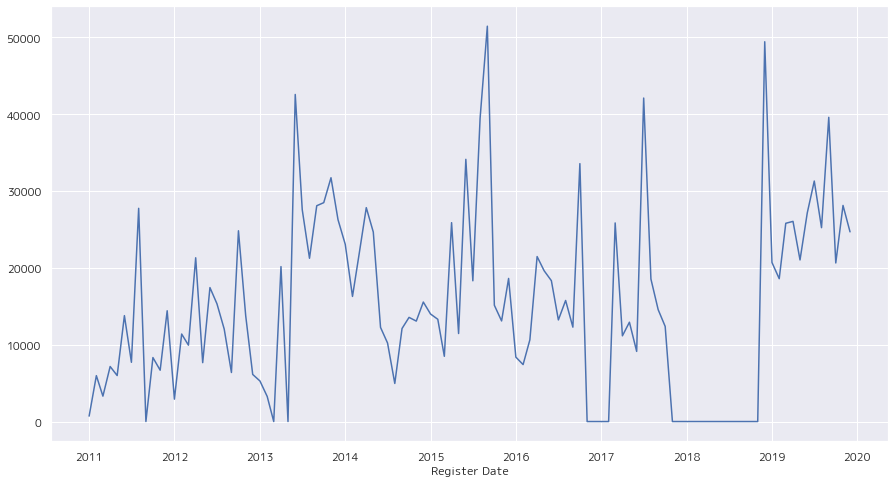

In [42]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [43]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-10-01', '2011-11-01', '2011-12-01', '2012-01-01',
               '2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-04-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
      

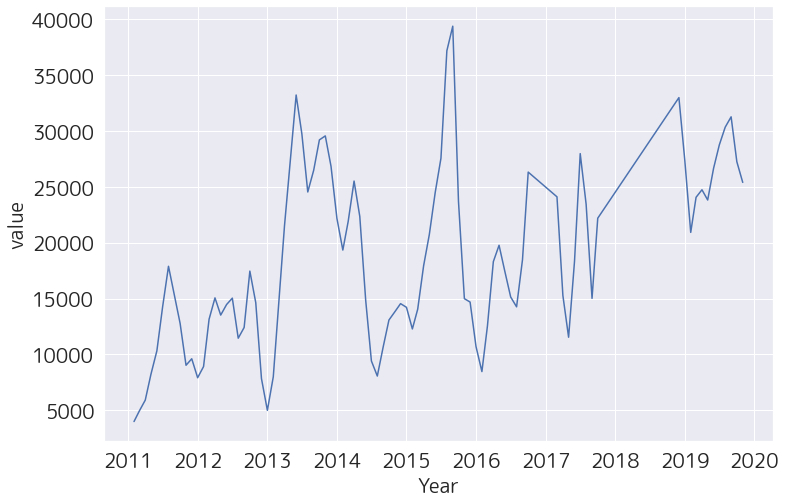

In [44]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [45]:
def series_to_supervised(data, n_in=4, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [46]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [47]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=1)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [48]:
# split into train and test sets
size = int(len(em_series_sample) * 0.7)
train_X, test_X = data[0:size], data[size:len(em_series_sample)]
train_y, test_y = target[0:size], target[size:len(em_series_sample)]
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 518.268
Test MAPE: 0.721


In [49]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [50]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.078,492.462,71.943
1,Decision_Tree,-0.127,503.641,83.476
2,Extra_Trees,-0.168,512.612,71.038
3,Random_Forest,-0.151,509.023,69.919
4,LGBM,-0.097,496.966,65.878
5,XGBoost,-0.173,513.861,70.807


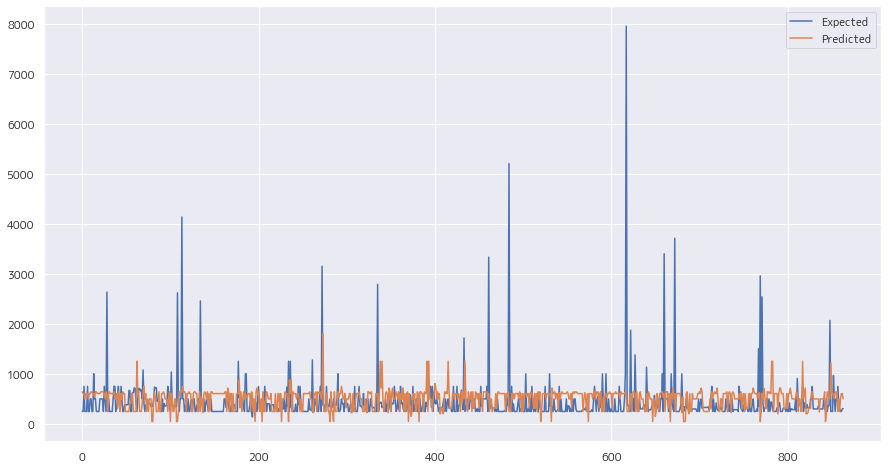

In [51]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=6.544727, expected=7.472553
predicted=6.900427, expected=6.886426
predicted=7.082154, expected=7.606084
predicted=7.163734, expected=5.526643
predicted=6.791036, expected=6.625255
predicted=6.737758, expected=7.723867
predicted=7.076201, expected=5.424950
predicted=6.487762, expected=6.625255
predicted=6.709187, expected=6.625255
predicted=6.465539, expected=9.433315
predicted=6.962828, expected=7.471133
predicted=7.141797, expected=5.526643
predicted=6.721954, expected=7.318402
predicted=7.401527, expected=7.318402
predicted=7.242158, expected=6.592493
predicted=7.221735, expected=6.625255
predicted=6.902905, expected=5.526643
predicted=6.483273, expected=6.912937
predicted=6.776951, expected=5.526643
predicted=6.434755, expected=7.472553
predicted=6.420934, expected=5.526643
predicted=6.287921, expected=7.318402
predicted=6.305894, expected=7.136080
predicted=6.720023, expected=6.219790
predicted=6.376476, expected=7.606084
predicted=6.979973, expected=6.912937
predicted=6.

predicted=6.803519, expected=5.526643
predicted=6.663648, expected=6.912937
predicted=6.696116, expected=6.960249
predicted=6.640571, expected=7.136080
predicted=6.497990, expected=5.526643
predicted=6.381675, expected=7.723867
predicted=6.666051, expected=5.526643
predicted=6.622276, expected=5.494665
predicted=6.361595, expected=5.526643
predicted=6.314164, expected=5.526643
predicted=5.831287, expected=6.625255
predicted=6.116975, expected=5.526643
predicted=5.658779, expected=6.219790
predicted=5.809536, expected=6.219790
predicted=5.974158, expected=6.625255
predicted=6.065313, expected=7.684784
predicted=6.497083, expected=6.625255
predicted=6.409149, expected=6.625255
predicted=6.657882, expected=6.219790
predicted=6.714528, expected=6.219790
predicted=6.656484, expected=5.844037
predicted=6.570939, expected=5.526643
predicted=6.183583, expected=8.338494
predicted=6.512484, expected=5.526643
predicted=6.179949, expected=7.136080
predicted=6.408082, expected=8.053741
predicted=6.

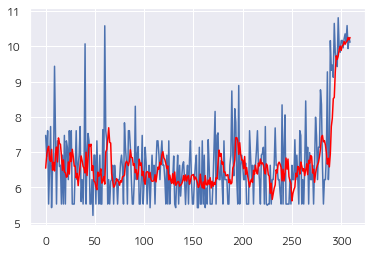

In [52]:
from statsmodels.tsa.arima.model import ARIMA

X = np.log(em_series).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RMSE: 7484.176
MAPE: 0.460


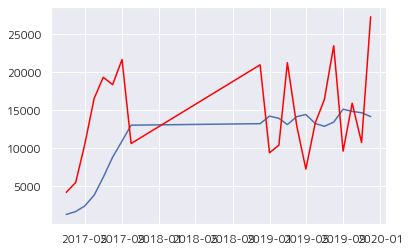

In [48]:
X = em_series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,1))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                         FutureWarning)
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

In [49]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

<ipython-input-49-ba1bbbfd531d>:6: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(test))
D:\Software\Anaconda\lib\site-packages\matplotlib\transforms.py:379: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 864x576 with 1 Axes>

In [50]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series_sample, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [53]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=13970.156928, expected=19630.924321
predicted=16532.014145, expected=18337.017284
predicted=17640.703483, expected=13227.815556
predicted=14857.035557, expected=15758.984444
predicted=15519.939796, expected=12286.560494
predicted=13970.559254, expected=33570.110741
predicted=20662.960181, expected=25851.685679
predicted=21225.141383, expected=11156.448148
predicted=15085.750827, expected=12930.139506
predicted=15083.669382, expected=9129.158025
predicted=12546.155189, expected=42109.030988
predicted=22489.237525, expected=18552.203457
predicted=18061.417547, expected=14564.129630
predicted=16441.874959, expected=12384.595556
predicted=15036.400221, expected=49438.048395
predicted=25008.481852, expected=20700.562099
predicted=20272.770571, expected=18592.996790
predicted=19498.428269, expected=25805.675802
predicted=21969.811821, expected=26056.319383
predicted=22805.138901, expected=21035.854444
predicted=21548.221408, expected=27156.274568
predicted=23706.912192, expected=31

In [54]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
# list_time_test = list(df_sum_month['month_year'][size:len(X)])
# list_time_test

df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
list_datetime
# df_sum_month[df_sum_month['month_year'].map(lambda x: '2017' in x)]

['2016-05-01',
 '2016-06-01',
 '2016-07-01',
 '2016-08-01',
 '2016-09-01',
 '2016-10-01',
 '2017-03-01',
 '2017-04-01',
 '2017-05-01',
 '2017-06-01',
 '2017-07-01',
 '2017-08-01',
 '2017-09-01',
 '2017-10-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01']

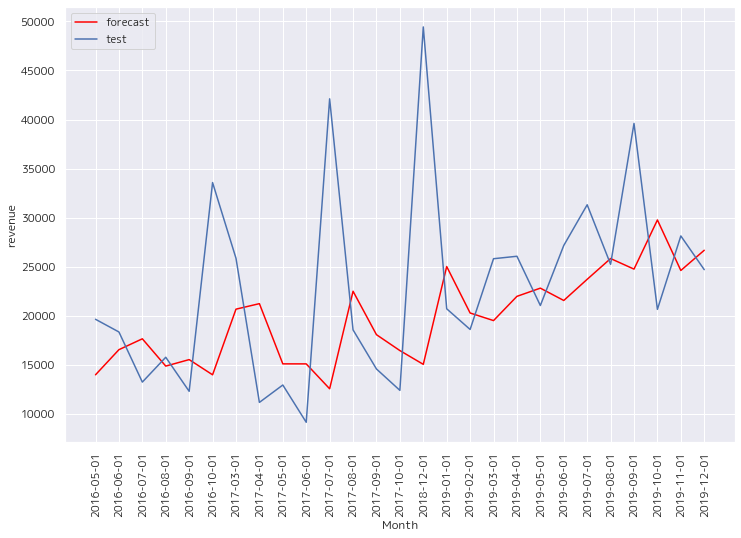

In [55]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

# plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.plot(em_series_month)
# plt.xticks(rotation = 90)
# plt.ylabel('revenue')
# # sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
# plt.legend(loc='best', labels=['forecast','test'])

In [56]:
X = em_series_month.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(test, predictions,squared=False)
mape =mean_absolute_percentage_error(test, predictions)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=18390.016234, expected=19630.924321
predicted=19206.269131, expected=18337.017284
predicted=18831.695538, expected=13227.815556
predicted=15974.886437, expected=15758.984444
predicted=16481.747241, expected=12286.560494
predicted=15004.385266, expected=33570.110741
predicted=23515.472120, expected=25851.685679
predicted=23173.582984, expected=11156.448148
predicted=17028.088461, expected=12930.139506
predicted=15460.283600, expected=9129.158025
predicted=14064.388145, expected=42109.030988
predicted=27561.872808, expected=18552.203457
predicted=20535.055001, expected=14564.129630
predicted=16644.289819, expected=12384.595556
predicted=15616.924694, expected=49438.048395
predicted=29524.137004, expected=20700.562099
predicted=21967.336579, expected=18592.996790
predicted=17758.276216, expected=25805.675802
predicted=26997.778357, expected=26056.319383
predicted=22284.916009, expected=21035.854444
predicted=20953.601083, expected=27156.274568
predicted=23887.719864, expected=31

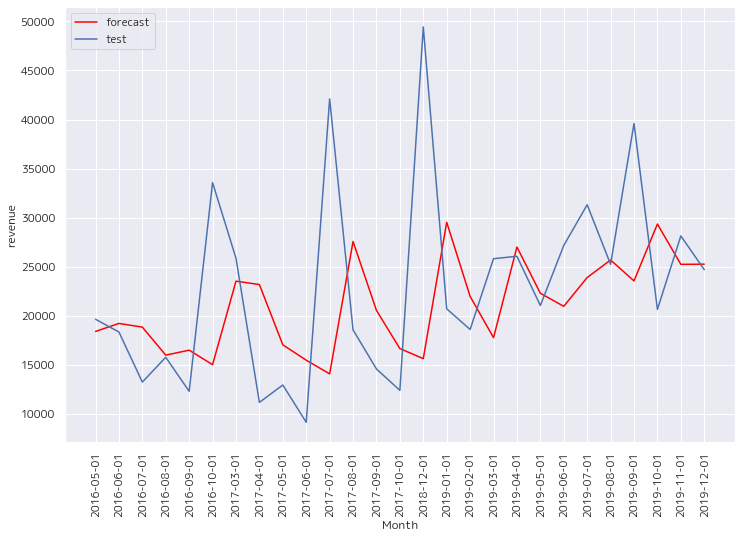

In [57]:
plt.figure(figsize=(12,8))
plt.plot(predictions, color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


RMSE: 98264.722
MAPE: 0.487


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


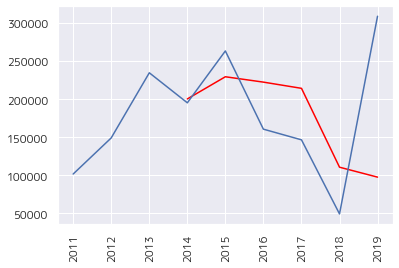

In [64]:
# X = np.log(em_series_year).values
X = em_series_year.values
# size = int(len(X) * 0.5)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
model = ARIMA(em_series_year, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2014-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.xticks(rotation = 90)
plt.plot(y_forecasted,color='red')
plt.plot(em_series_year)
plt.show()
# predictions = list()|
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [57]:
# df_sum_year.reset_index(inplace=True)
# df_sum_year['year'] = df_sum_year['year'].astype(str)
list_datetime = list(df_sum_year['year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
list(df_sum_year['year'][6:])

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

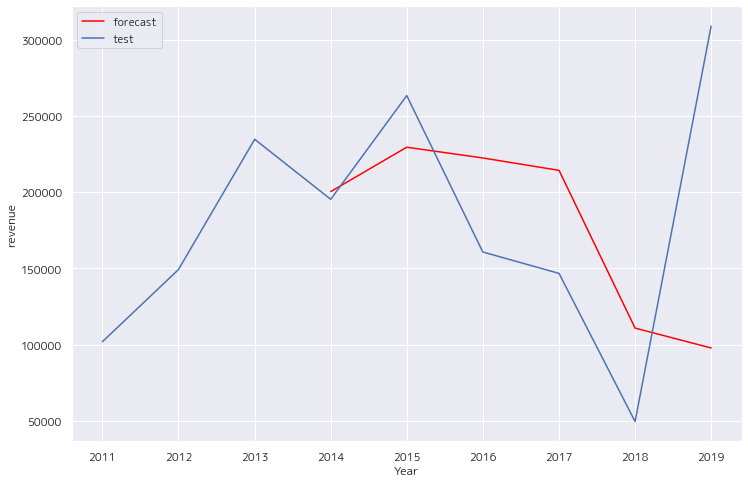

In [65]:
plt.figure(figsize=(12,8))
plt.plot(y_forecasted, color='red')
plt.plot(em_series_year)
# plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('revenue')
# sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
plt.legend(loc='best', labels=['forecast','test'])

In [66]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [67]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1982.7833235803098
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1698.1831203577574
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1665.986991926892
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1385.7193425808086
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1683.8362904663777
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1643.5251817513379
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1403.1813048499891
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1383.2737938190285
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1924.9525860926606


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1656.2675250117913
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1641.4449800331279
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1360.3671544757278
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1694.124083396273
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1643.5155538824215
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1404.458125179162


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1360.3790268631285
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1863.2215027463812
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1607.1477070476728
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1670.8674518896369
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1371.4771271001146
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1627.5256632942283
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1608.9748548474417
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1404.7821227605486
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1367.6246103650928


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1812.6070892418961
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1560.9806732046275
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1624.56146562556
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1326.2488693682646
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1602.9357790973677
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1562.9136745773305


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1384.0230967822622
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1327.3170435283566
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1879.3469720880887
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1625.4454605157873
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1660.9167899738138
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1377.3785531912022


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1625.6731752330238
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1627.9078963205563
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1381.5190327274374
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1378.544786689905
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1835.240487578445


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1584.309362743688
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1640.3771211023266
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1347.5592188439505


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1604.699870182405
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1586.6125822292106
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1381.5421955526642


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1348.829217652679
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1848.4009263550306
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1597.5849969069266
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1655.6647488812678
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1357.2435756983377
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1597.7917939583283
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1598.0573255395116
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1373.7887805646953


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1359.18935894085
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1813.447408586416
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1560.8467468864558
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1620.6831545092186
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1328.0999538270519


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1582.7757472498677
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1561.4754873972415
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1364.1875242888589


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1329.1348779260666


In [37]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2752      0.149      8.554      0.000       0.983       1.567
ar.L2         -0.2554      0.223     -1.146      0.252      -0.692       0.182
ar.L3         -0.0111      0.226     -0.049      0.961      -0.454       0.431
ar.L4          0.1669      0.187      0.894      0.371      -0.199       0.533
ar.L5         -0.1708      0.147     -1.159      0.246      -0.460       0.118
ma.L1         -0.9840      0.171     -5.753      0.000      -1.319      -0.649
ma.S.L12      -0.1550      0.230     -0.674      0.501      -0.606       0.296
sigma2      1.047e+08   1.35e-09   7.77e+16      0.000    1.05e+08    1.05e+08


D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


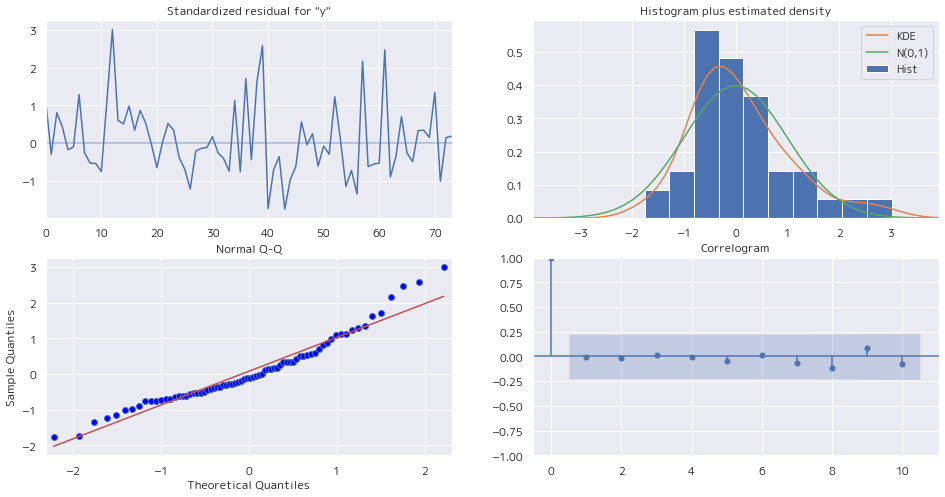

In [38]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

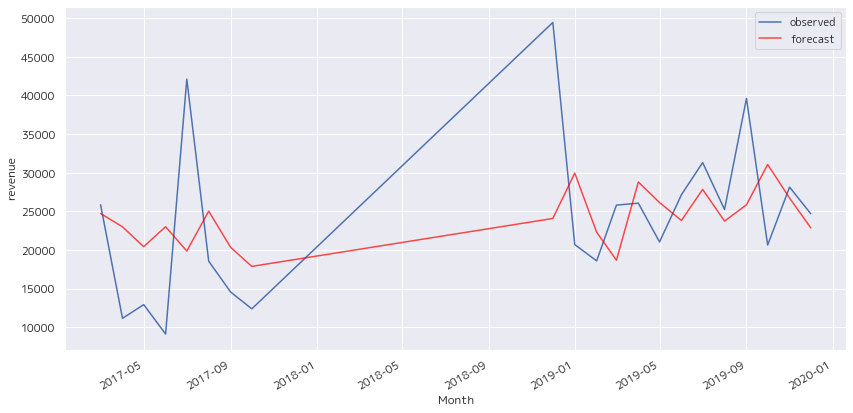

In [39]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [40]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 10109.031
MAPE: 0.380


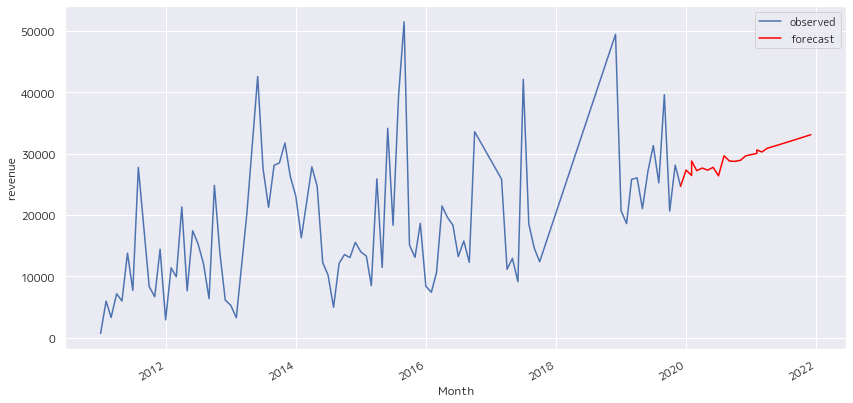

In [41]:
index = pd.to_datetime(['2019-12-01','2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_month[len(em_series_month)-1]
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [42]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,27318.652341
2020-02-01,26433.633915
2020-03-01,27223.092681
2020-02-01,28800.104690
2020-04-01,27643.579244
2020-05-01,27307.563158
2020-06-01,27764.696084
2020-07-01,26376.809258
2020-08-01,29641.058791
2020-09-01,28783.560431


In [43]:
# mod =SARIMAX(em_series_year,
#                                 order=(0, 0, 1),
#                                 seasonal_order=(0, 0, 1, 2),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)

# results = mod.fit()

# print(results.summary().tables[1])

mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9629         -0       -inf      0.000       0.963       0.963
ma.S.L12            0         -0        nan        nan           0           0
sigma2      1.287e+10         -0       -inf      0.000    1.29e+10    1.29e+10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
D:\Software\Anaconda\lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
D:\Software\Anaconda\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarnin

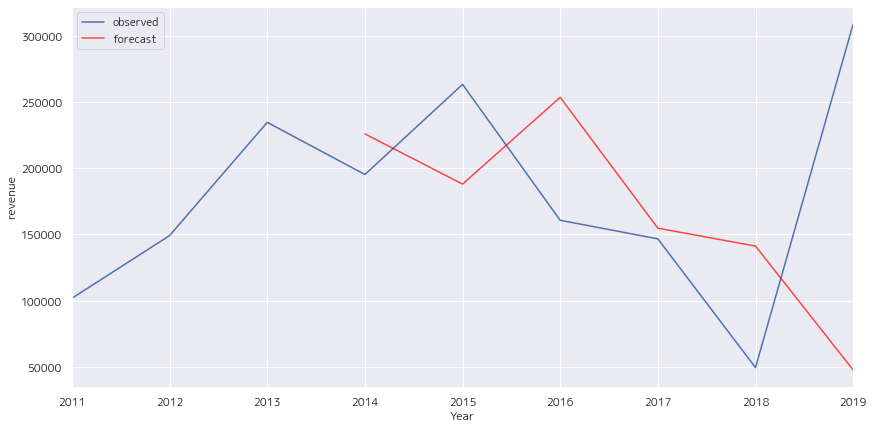

In [44]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2011-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7),color='red')

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [45]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
# mape = mean_absolute_percentage_error(y_forecasted,y_truth)

print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 123854.208
MAPE: 0.630


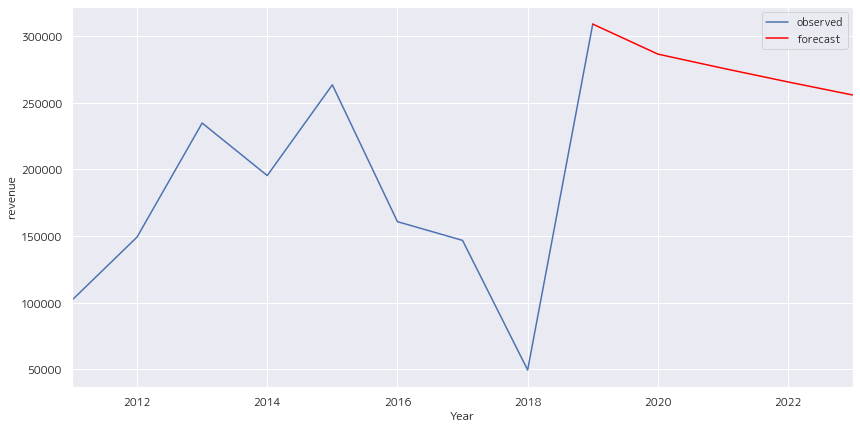

In [46]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_year[len(em_series_year)-1]
ax = em_series_year.plot(label='observed', figsize=(14, 7))
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [47]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,286423.659840
2021-01-01,275783.701702
2022-01-01,265538.992717
2023-01-01,255674.850320


In [48]:
df_1nz  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'F23A' in x)]
df_1nz

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
30281,20,2011-01-25,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: SUBARU...","SUBARU, NISSAN, TOYOTA, HONDA","SUBARU, NISSAN, TOYOTA, HONDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","G.E. TRADING CO., LTD",...,CFR,3250.00,3250.00,3250.00,[F23A],HONDA,2011-01,2011,1,1
30288,971,2011-01-17,8407343009,"ДВИГАТЕЛИ-17ШТ,БЫВШ.В УПОТР.КАРБЮРАТ.ДЛЯ ЛЕГК ...","TOYOTA MOTOR CO.,NISSAN MOTOR CO.,MAZDA MOTOR ...","TOYOTA,NISSAN,MAZDA,HONDA.",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","SUNTEC CO., LTD.",...,CFR,3860.00,3860.00,5357.36,"[F23A, D16A]",HONDA,2011-01,2011,2,2
30290,995,2011-01-21,8407343009,ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.В СБОРЕ С НАВЕСНЫМ ОБО...,"TOYOTA,HONDA,NISSAN,MMC,MAZDA,SUBARU,SUZUKI","TOYOTA,HONDA,NISSAN,MMC,MAZDA,SUBARU,SUZUKI",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","TATSUMI SHOKAI CO.,LTD,3-8-7,IIDABASHI,CHIYODA...",...,CFR,14030.00,14030.00,7625.00,"[F23A, F20B, D16A]",HONDA,2011-01,2011,3,3
30293,1328,2011-02-03,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ ЛЕГКОВЫХ А/М, Б/У, ОБЪЕМО...","TOYOTA, HONDA, NISSAN, MAZDA, FUJI HEAVI, SUZU...","TOYOTA, HONDA, NISSAN, MAZDA, SUBARU, SUZUKI, MMC",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",KAHLON INTERNATIONAL,...,CFR,2678.52,2678.52,2525.00,[F23A],HONDA,2011-02,2011,1,1
30294,1330,2011-02-03,8407343009,"ДВИГАТЕЛИ-8ШТ, БЫВШ. В УПОТР. КАРБЮР,ОБЪЕМ 120...","TOYOTA MOTOR CO.,HONDA MOTORS CO.LTD., TOYOTA,...","TOYOTA,HONDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",PARS TRADING,...,CFR,1820.00,1820.00,1893.13,"[F23A, D16A]",HONDA,2011-02,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39120,258180,2019-12-01,8407343009,"ДВИГАТЕЛИ-5ШТ,БЫВШ.В УПОТР,КАРБЮРАТ. ОБЪЕМ 133...",HONDA MOTOR CO.,HONDA,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",MS PLANNING CO. LTD.,...,CFR,1110.00,1110.00,1713.28,"[F23A, F23A, L13A, H23A, D15B]",HONDA,2019-12,2019,4,5
39131,258411,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,340.00,340.00,512.20,[F23A],HONDA,2019-12,2019,1,1
39144,258985,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,HONDA,HONDA,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,1355.00,1320.00,1995.27,"[F22B, F23A, F23A, B20B]",HONDA,2019-12,2019,3,4
39146,259070,2019-12-01,8407343009,"ДВИГАТЕЛИ-3ШТ,БЫВШ.В УПОТР,КАРБЮРАТ.ОБЪЕМ 1972...",HONDA MOTOR CO.,HONDA.,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SUNTEC CO. LTD.,...,CFR,740.00,740.00,1147.37,"[F23A, B20B, F20B]",HONDA,2019-12,2019,3,3


In [49]:
df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'F23A'))
unit_price_1nz = df_1nz[(df_1nz.Quantity == 1) & (df_1nz.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
df_1nz['total_price'] = df_1nz.apply(lambda x : check_count_em(x,unit_price_1nz),axis=1)

<ipython-input-49-9eb91f3018c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'F23A'))
<ipython-input-49-9eb91f3018c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
<ipython-input-49-9eb91f3018c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [50]:
df_1g  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'D15B' in x)]
df_1g

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
30289,974,2011-01-18,8407343009,"ДВИГАТЕЛИ БЕНЗИН.-21ШТ.,БЫВ.В УПОТРЕБЛ.ДЛЯ ЛЕК...","HONDA MOTOR COMPANY,TOYOTA MOTOR CORPORATION,S...","HONDA,TOYOTA,SUBARU,MITSUBISHI,NISSAN,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","YAMADA MOTOR CO.,LTD.16-6,SHIMIZU-KU NISHITAKA...",...,CFR,4594.0,4594.0,6891.00,[D15B],HONDA,2011-01,2011,1,1
30297,1485,2011-02-04,8407343009,"ДВИГАТЕЛИ-20ШТ, БЫВШ. В УПОТР. КАРБЮР. ОБЪЕМ 1...","TOYOTA MOTOR CO.,HONDA MOTOR CO.,NISSAN MOTOR ...","TOYOTA,HONDA,NISSAN,SUZUKI,MITSUBISHI,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",M S PLANNING CO. LTD.,...,CFR,4405.5,4405.5,5405.86,"[K24A, ZC, B20B, D15B, F20B]",HONDA,2011-02,2011,5,5
30308,1951,2011-02-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"TOYOTA MOTOR CORPORATION,HONDA MOTOR CO.,LTD,M...","TOYOTA,MITSUBISHI,HONDA,SUBARU,NISSAN,DAIHATSU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","HIKARI SYOJI CO.,LTD 27 YAWATAKUBOTA YAWATA-CI...",...,CFR,4630.0,4630.0,4230.00,[D15B],HONDA,2011-02,2011,1,1
30313,2634,2011-02-24,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","NISSAN, MAZDA, HONDA, TOYOTA",NISSAN,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","FESCO LINES VLADIVOSTOK, LLC 34POSYETSKAYA STR...",...,CFR,3762.0,3762.0,1782.00,[D15B],HONDA,2011-02,2011,1,1
30320,2679,2011-02-25,8407343009,"ДВС БЕНЗ.-64ШТ,БЫВШ.В УПОТРЕБ.ДЛЯ Л/А С К/П,С ...","TOYOTA MOTOR CORPORATION,MAZDA MOTOR CORPORATI...","TOYOTA,MAZDA,HONDA,SUBARU,MITSUBUSHI,NISSAN,DA...",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","HIKARI SYOJI CO.,LTD.",...,CFR,10960.0,10960.0,11959.25,"[H23A, D15B]",HONDA,2011-02,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39126,258296,2019-12-01,8407343009,"ДВИГАТЕЛЬ АВТОМОБИЛЬНЫЙ БЫВШИЙ В УПОТРЕБЛЕНИИ,...",HONDA MOTOR CO. LTD,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","HK, HKG, Hong Kong",KAIHO INDUSTRY CO.LTD,...,CFR,750.0,750.0,1125.08,"[LDA, D15B, D15B, D15B]",HONDA,2019-12,2019,2,4
39127,258304,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,HONDA MOTOR CORPORATION,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","TW, TWN, Taiwan",VL JP CO. LTD,...,CFR,1920.0,1920.0,2890.00,"[L13A, L13A, L13A, D15B, D17A, D17A, D16A, D16A]",HONDA,2019-12,2019,4,8
39145,259058,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",HONDA MOTOR CO. LTD.,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,2686.0,2686.0,4056.00,"[D15B, D15B, D15B, D15B]",HONDA,2019-12,2019,1,4
39150,259170,2019-12-01,8407343009,ЗАПАСНЫЕ ЧАСТИ ДЛЯ А/М БЫВШИЕ В УПОТРЕБЛЕНИИ: ...,HONDA MOTOR CO.,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",PIONEER COMPANY LTD.,...,CFR,185.0,185.0,279.35,[D15B],HONDA,2019-12,2019,1,1


In [51]:
df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'D15B'))
unit_price_1g = df_1g[(df_1g.Quantity == 1) & (df_1g.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_1g['total_price'] = df_1g.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-51-bc9c92a6926c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'D15B'))
<ipython-input-51-bc9c92a6926c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-51-bc9c92a6926c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [52]:
df_fp  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'L13A' in x)]
df_fp

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
30284,54,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIRAYASU CO.,LTD",...,CFR,7450.00,7450.00,3950.00,"[B20B, L13A, G20A]",HONDA,2011-01,2011,3,3
30296,1357,2011-02-02,8407343009,"ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ОБЪЁМОМ БОЛЕЕ 1000СМ3, ...","DAIHATSU, TOYOTA, HONDA, MITSUBISHI, NISSAN, S...",DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","JAPANTREK CO.,LTD",...,CFR,8250.00,8250.00,4500.00,"[L15A, B20B, L13A, D16A, K20A]",HONDA,2011-02,2011,5,5
30300,1625,2011-02-09,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",TOYAMA KAIGAI BOEKI CO.LTD.,...,CFR,1750.00,1750.00,500.00,"[B20B, L13A, F20B, F20B, D16A]",HONDA,2011-02,2011,4,5
30304,1688,2011-02-08,8407343009,"ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЕНЗИНОВЫЕ, Б/У...","TOYOTA, MAZDA, NISSAN, SUBARU, MITSUBISHI, HONDA",TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",MG TRADING,...,CFR,3730.00,3730.00,2800.00,[L13A],HONDA,2011-02,2011,1,1
30306,1909,2011-02-11,8407343009,"ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЕНЗИНОВЫЕ, Б/У...","TOYOTA, NISSAN, HONDA, MITSUBISHI",TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","KAIHO SANGYO CO.,LTD.",...,CFR,1903.85,1903.85,1473.08,"[F23A, L13A]",HONDA,2011-02,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39125,258288,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",LUXMAN ENTERPRISE JAPAN LTD.,...,CFR,370.00,370.00,562.40,"[L13A, F20B]",HONDA,2019-12,2019,2,2
39127,258304,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,HONDA MOTOR CORPORATION,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","TW, TWN, Taiwan",VL JP CO. LTD,...,CFR,1920.00,1920.00,2890.00,"[L13A, L13A, L13A, D15B, D17A, D17A, D16A, D16A]",HONDA,2019-12,2019,4,8
39133,258413,2019-12-01,8407343009,"ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,250.00,250.00,376.62,[L13A],HONDA,2019-12,2019,1,1
39134,258414,2019-12-01,8407343009,ЗАП.ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ. Б/У: ДВИГАТЕЛИ БЫВШ...,HONDA,HONDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",ROOTS CO. LTD,...,CFR,250.00,250.00,376.62,[L13A],HONDA,2019-12,2019,1,1


In [53]:
df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'L13A'))
unit_price_1g = df_fp[(df_fp.Quantity == 1) & (df_fp.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_fp['total_price'] = df_fp.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-53-b245907ec55e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'L13A'))
<ipython-input-53-b245907ec55e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-53-b245907ec55e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [54]:
df_3s['name_em'] = 'B20B'
df_1nz['name_em'] = 'F23A'
df_1g['name_em'] = 'D15B'
df_fp['name_em'] = 'L13A'

<ipython-input-54-c7f9e1169c69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['name_em'] = 'B20B'
<ipython-input-54-c7f9e1169c69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['name_em'] = 'F23A'
<ipython-input-54-c7f9e1169c69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [55]:
df_best_engine  = pd.concat([df_3s,df_1nz,df_1g,df_fp],axis=0)

In [45]:
df_group_year = df_best_engine.groupby(['year','name_em'])['total_price'].sum().reset_index()
df_group_year

,year,name_em,total_price
0,2011,B20B,101809.992469
1,2011,D15B,97071.987500
2,2011,F23A,56020.858571
3,2011,L13A,44711.919000
4,2012,B20B,149164.999259
5,2012,D15B,132670.122250
6,2012,F23A,98573.934286
7,2012,L13A,70377.829000
8,2013,B20B,234707.588025
9,2013,D15B,154155.741750


Text(0.5, 0, 'Year')

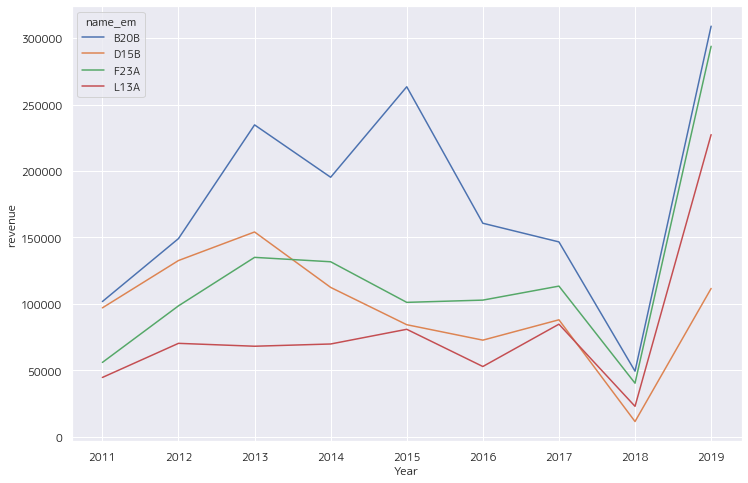

In [46]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='total_price',hue='name_em',data=df_group_year)
plt.ylabel('revenue')
plt.xlabel('Year')

In [48]:
df_group_month = df_best_engine.groupby(['month_year','name_em'])['total_price'].sum().reset_index()
df_group_month

,month_year,name_em,total_price
0,2011-01,B20B,702.597531
1,2011-01,D15B,6891.000000
2,2011-01,F23A,3891.808571
3,2011-01,L13A,227.573000
4,2011-02,B20B,5973.487654
...,...,...,...
347,2019-11,L13A,22074.416000
348,2019-12,B20B,24691.850494
349,2019-12,D15B,14615.871750
350,2019-12,F23A,13202.148571


Text(0.5, 0, 'Month')

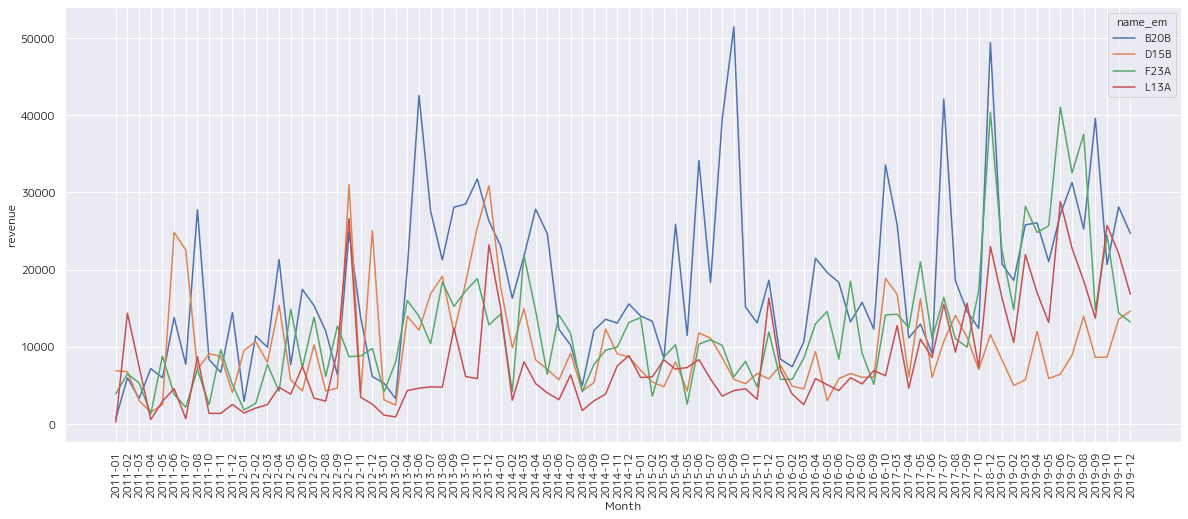

In [49]:
plt.figure(figsize=(20,8))
sns.lineplot(x='month_year',y='total_price',hue='name_em',data=df_group_month)
plt.xticks(rotation = 90)
plt.ylabel('revenue')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

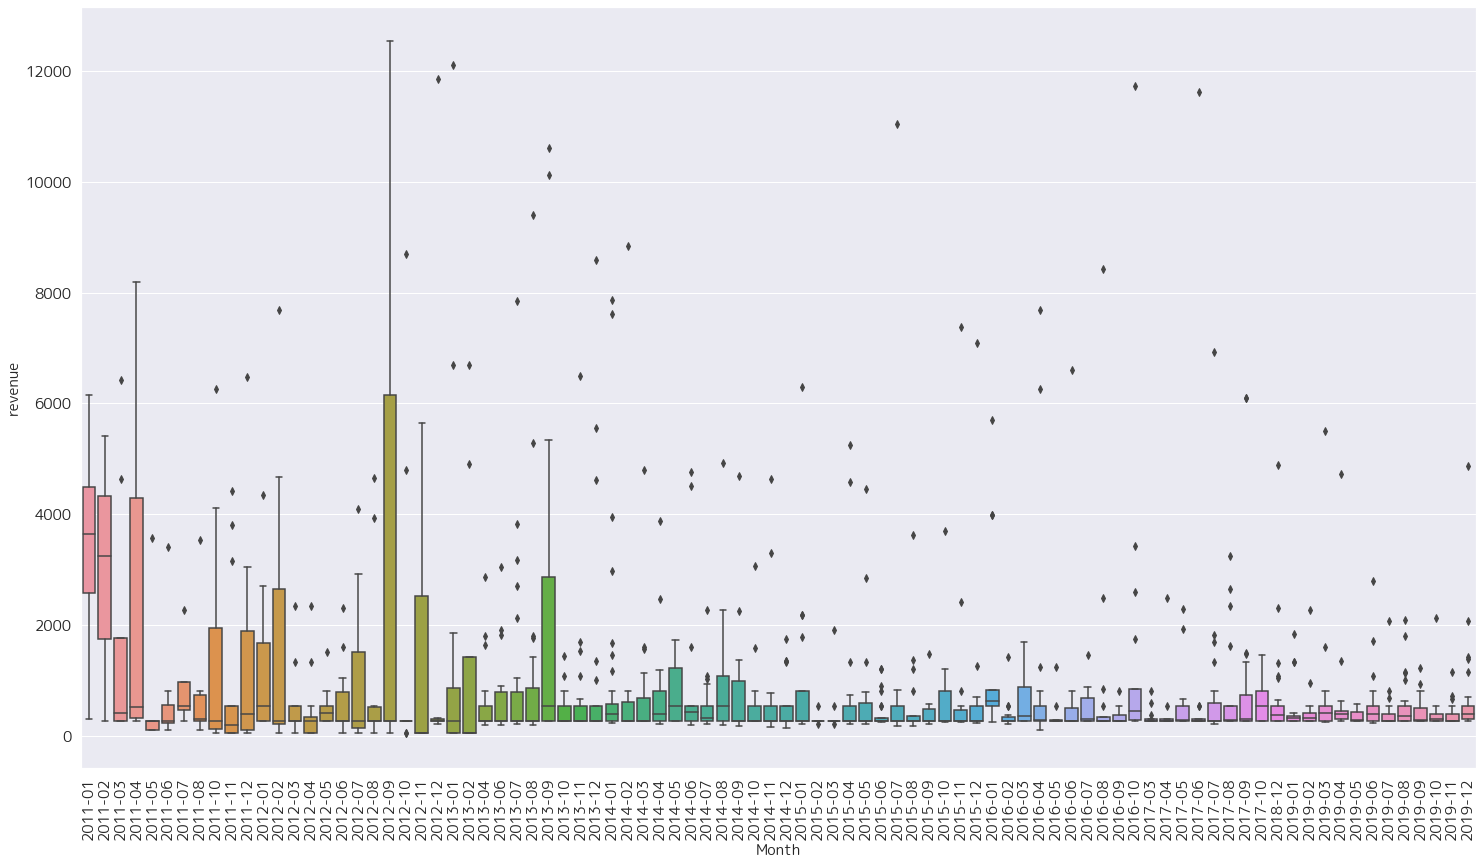

In [97]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

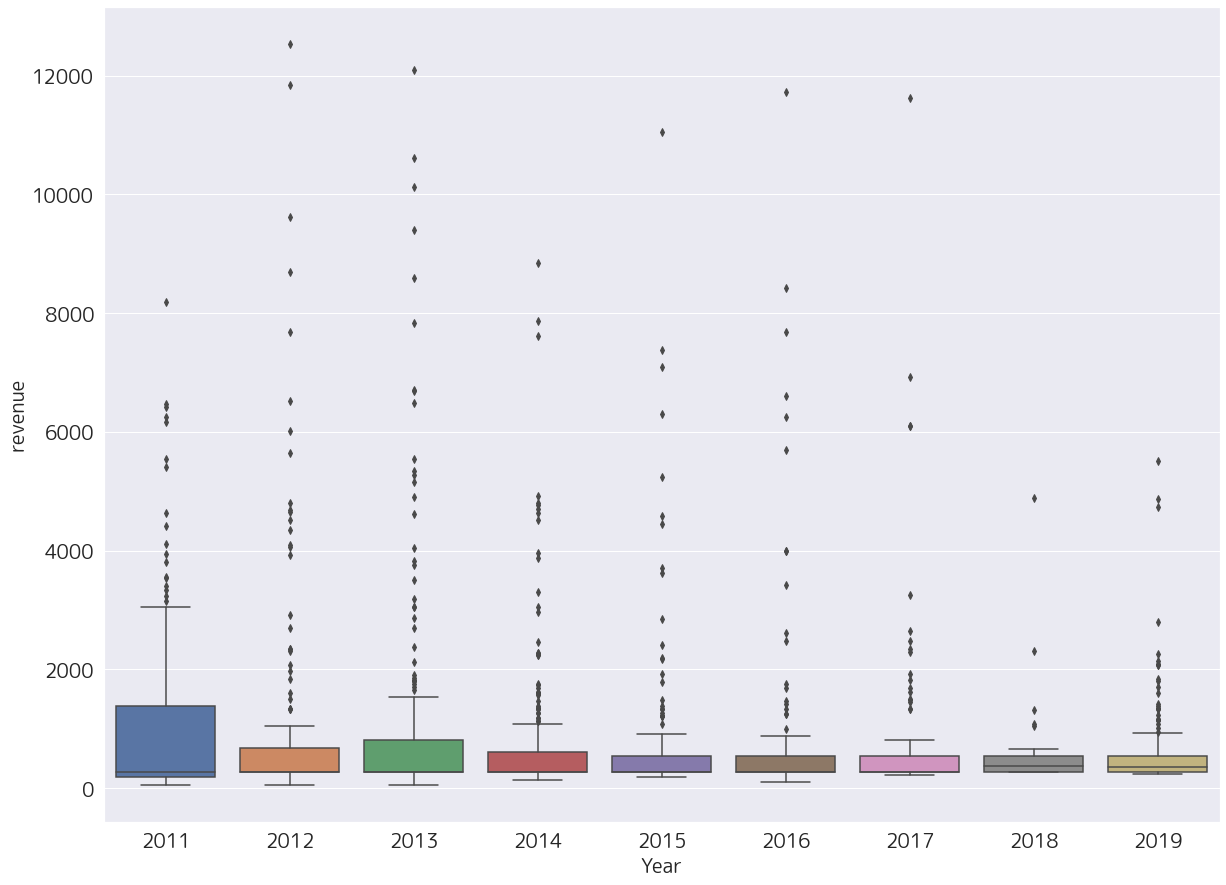

In [98]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_3s)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

# Engine Model F23A

In [56]:
df_sum_day = df_1nz.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1nz.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1nz.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1nz.total_price.values,index=df_1nz['Register Date'])

Text(0.5, 0, 'Month')

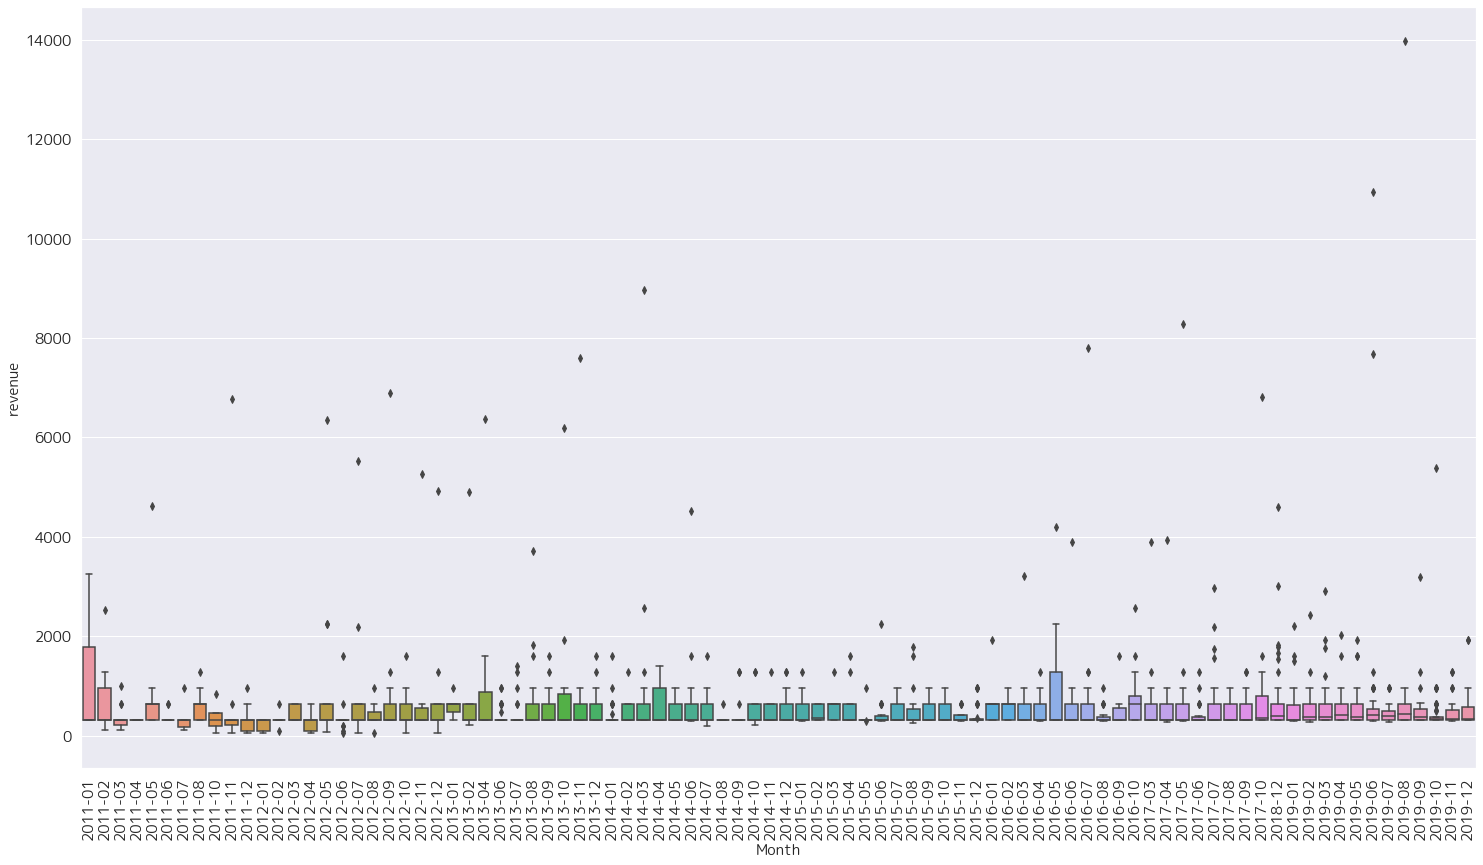

In [138]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

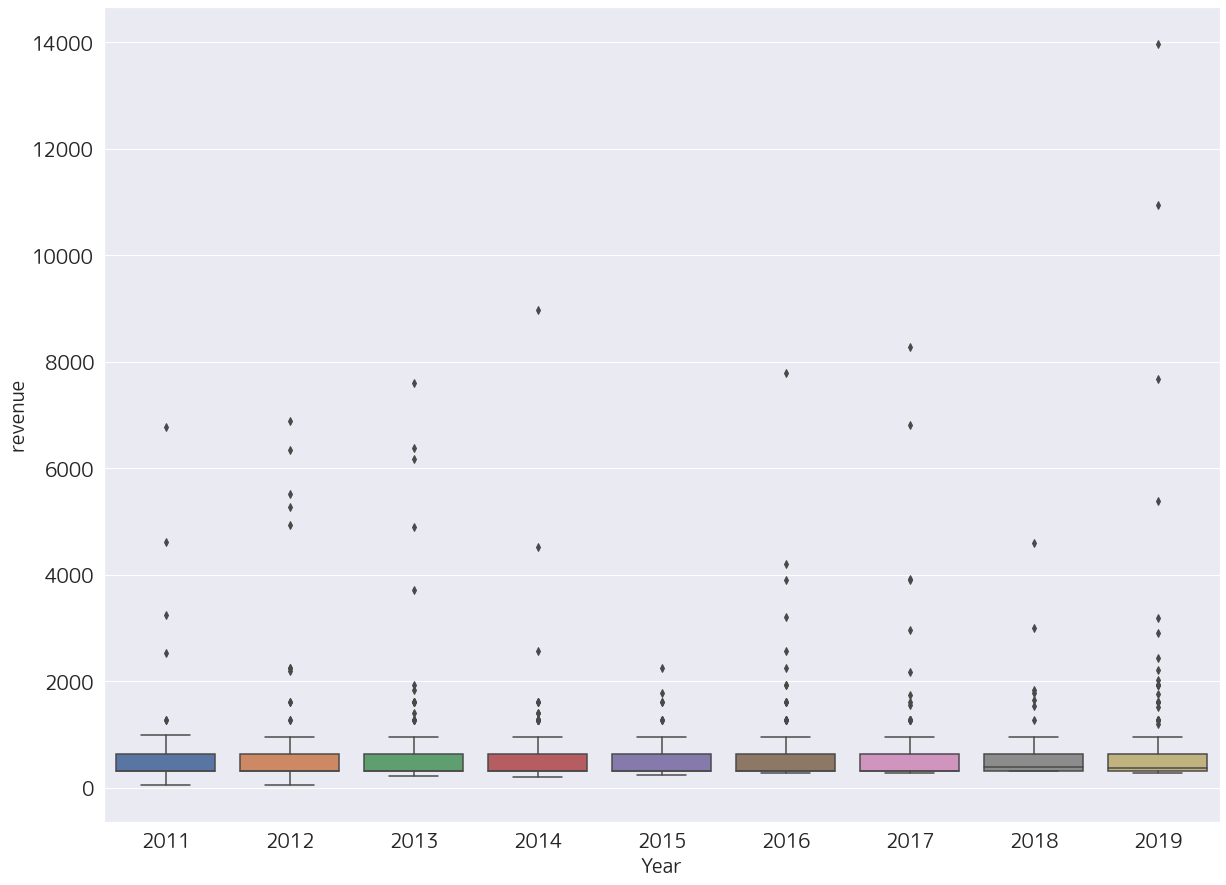

In [139]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_1nz)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

In [140]:
X = np.log(em_series_month).values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=6810.514588, expected=14568.032857
predicted=9447.958832, expected=8392.660000
predicted=9877.520325, expected=18491.567143
predicted=10005.070998, expected=9139.302857
predicted=9783.292560, expected=5134.468571
predicted=11329.198725, expected=14119.788571
predicted=9107.283063, expected=14217.138571
predicted=8878.684206, expected=12484.638571
predicted=13467.481352, expected=20998.437143
predicted=12618.786256, expected=11044.817143
predicted=11281.439678, expected=16394.580000
predicted=14051.140361, expected=11045.077143
predicted=12280.347905, expected=9948.032857
predicted=13344.355877, expected=17297.624286
predicted=12730.175145, expected=40392.150000
predicted=14364.570997, expected=22421.094286
predicted=19543.486493, expected=14810.334286
predicted=19773.108077, expected=28189.065714
predicted=16359.118346, expected=24812.742857
predicted=18347.067257, expected=25681.707143
predicted=26279.994840, expected=41062.312857
predicted=25585.620196, expected=32520.57714

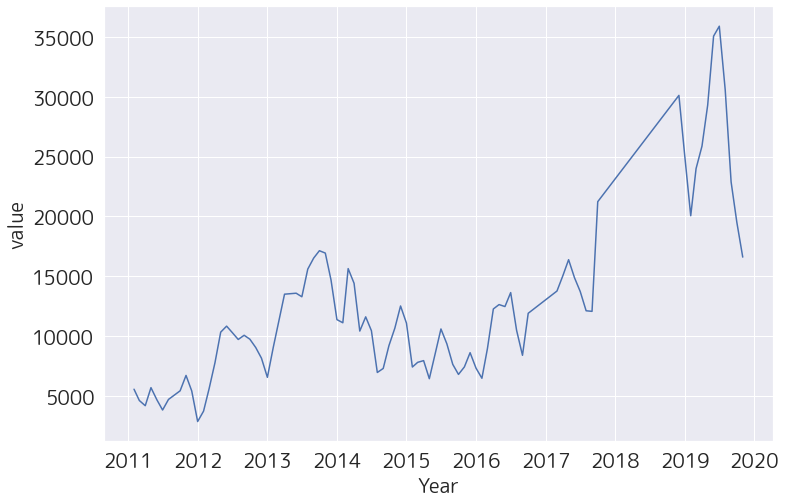

In [141]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

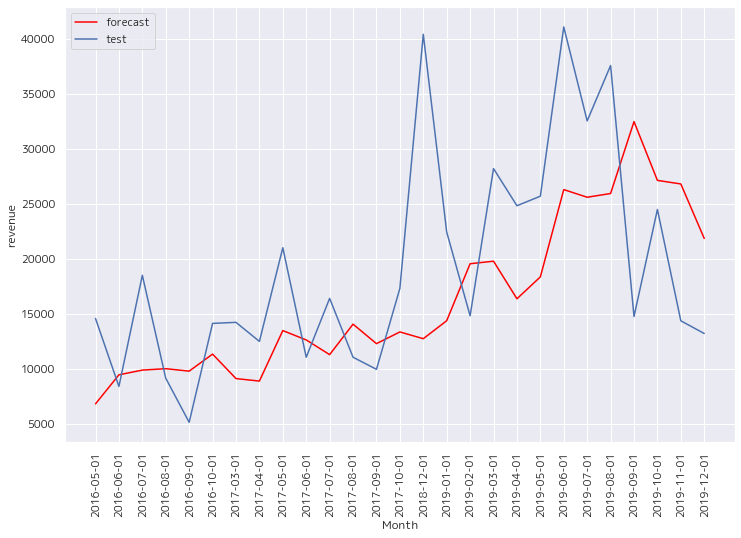

In [142]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


In [143]:
X = np.log(em_series_year).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=98315.496475, expected=113430.345714
predicted=104053.199785, expected=40392.150000
predicted=81079.741604, expected=293829.800000
RMSE: 128509.112
MAPE: 0.811


In [144]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations 

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

2.0 [(0, 0, 0), (0, 1, 0, 12)]


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

In [57]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3191      0.548     -0.583      0.560      -1.393       0.754
ar.L2         -0.0075      0.568     -0.013      0.990      -1.121       1.106
ar.L3          0.0876      0.568      0.154      0.877      -1.025       1.200
ar.L4         -0.3974      0.537     -0.740      0.459      -1.450       0.655
ar.L5         -0.1568      0.479     -0.327      0.743      -1.096       0.782
ma.L1          1.0422      0.486      2.146      0.032       0.090       1.994
ar.S.L12       0.5792      0.929      0.623      0.533      -1.242       2.401
ar.S.L24      -0.0386      1.500     -0.026      0.979      -2.978       2.901
ar.S.L36       0.2342      1.376      0.170      0.865      -2.462       2.930
ar.S.L48       0.4526      0.616      0.735      0.462      -0.754       1.659
ar.S.L60       0.6964      1.020      0.683      0.4

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

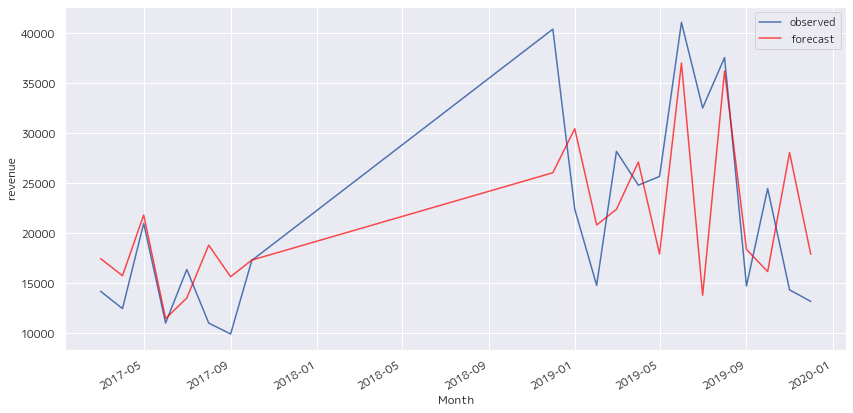

In [59]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [60]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 7526.123
MAPE: 0.303


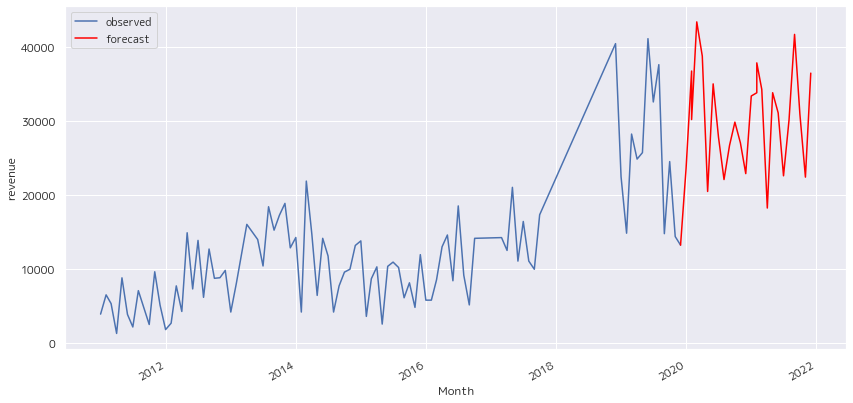

In [61]:
index = pd.to_datetime(['2019-12-01','2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_month[len(em_series_month)-1]
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [62]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,23550.704059
2020-02-01,36693.830319
2020-03-01,43326.308605
2020-02-01,30144.930963
2020-04-01,38709.708170
2020-05-01,20444.978841
2020-06-01,34960.057920
2020-07-01,27766.625710
2020-08-01,22052.697669
2020-09-01,26661.148119


In [63]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2780      1.928      0.663      0.507      -2.500       5.056
ma.L1         -1.6946      8.427     -0.201      0.841     -18.212      14.822
sigma2      1.003e+10   7.66e-10   1.31e+19      0.000       1e+10       1e+10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


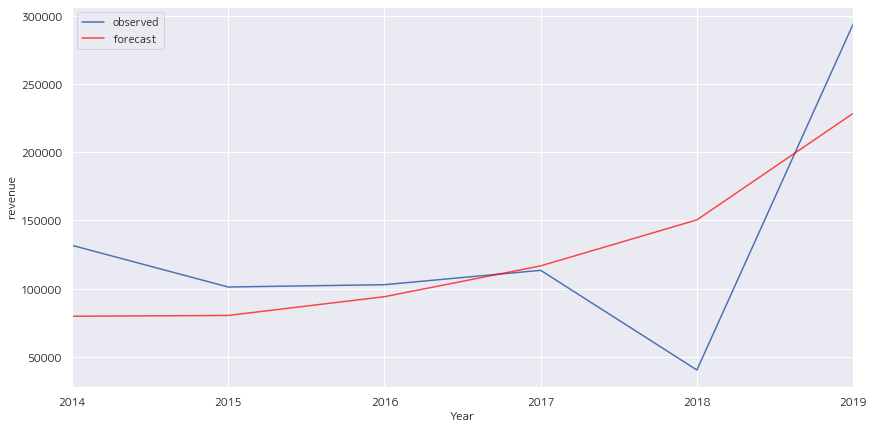

In [64]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [65]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 57156.296
MAPE: 0.610


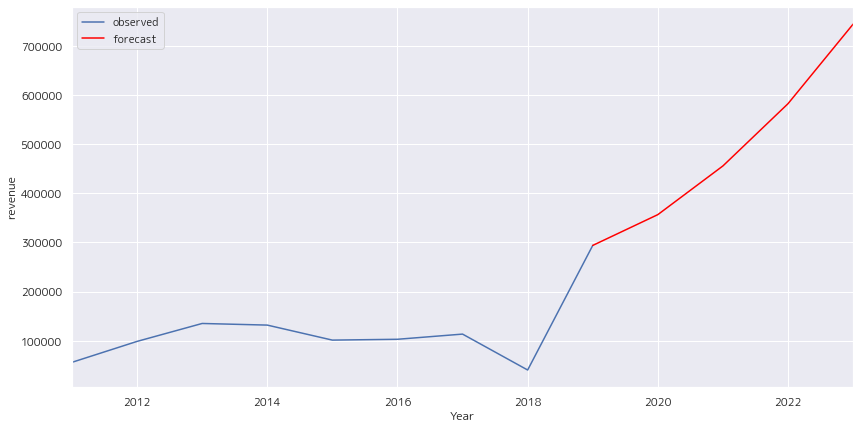

In [66]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_year[len(em_series_year)-1]
ax = em_series_year.plot(label='observed', figsize=(14, 7))
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [67]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,356475.393574
2021-01-01,455571.020329
2022-01-01,582213.971302
2023-01-01,744062.052354


# Engine Model D15B

In [68]:
df_sum_day = df_1g.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1g.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1g.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1g.total_price.values,index=df_1g['Register Date'])

Text(0.5, 0, 'Month')

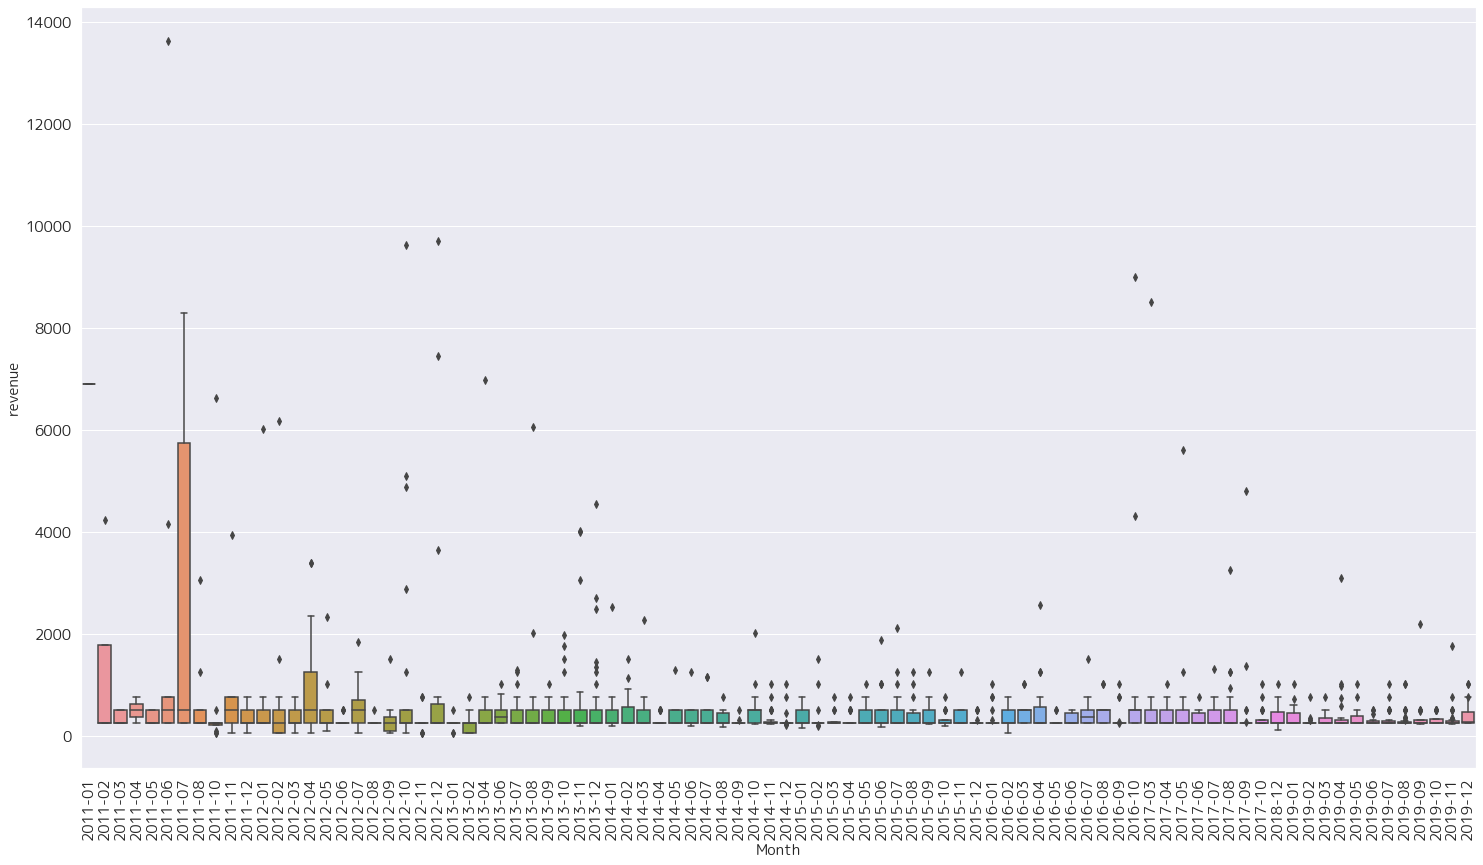

In [53]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_1g)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

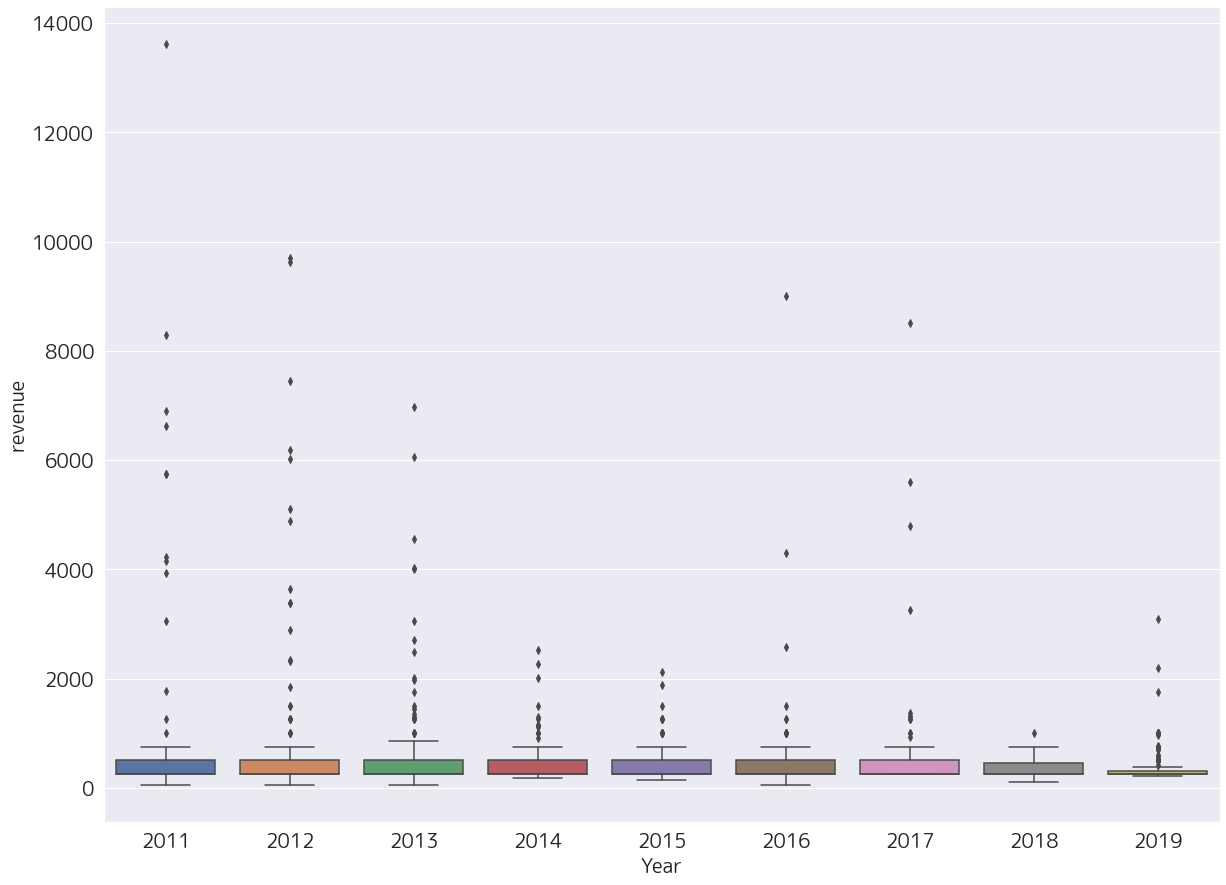

In [54]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_1g)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

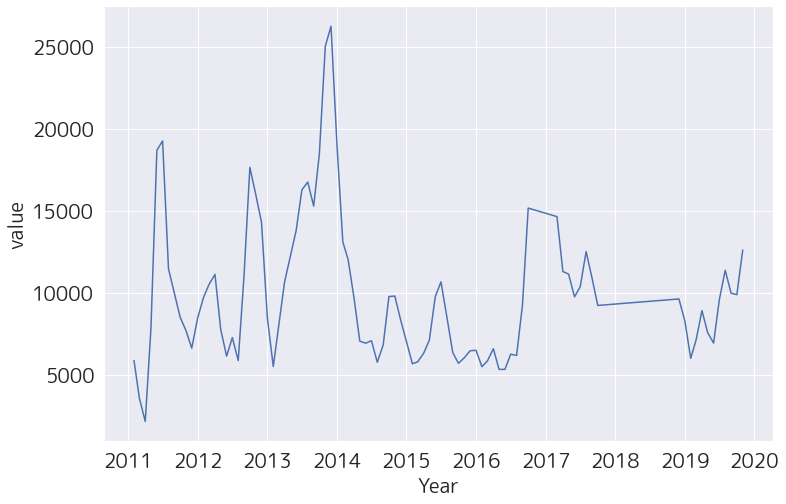

In [55]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [333]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=8563.907002, expected=17784.000000
predicted=12598.944140, expected=23826.150000
predicted=14373.333012, expected=26631.280000
predicted=21900.953163, expected=24247.160000
predicted=19913.711848, expected=19864.550000
predicted=21774.249038, expected=10312.190000
predicted=20950.499374, expected=13706.370000
predicted=16254.178418, expected=12758.300000
predicted=15238.314845, expected=23736.850000
predicted=13699.496898, expected=16121.070000
predicted=17763.960543, expected=32307.130000
predicted=16770.007810, expected=31277.850000
predicted=21828.792673, expected=9490.730000
predicted=22272.012157, expected=19383.310000
predicted=18238.193422, expected=50400.250000
predicted=16860.114263, expected=29262.740000
predicted=19446.451409, expected=17836.900000
predicted=24771.799494, expected=25864.310000
predicted=23620.680138, expected=24677.910000
predicted=20294.893826, expected=21095.590000
predicted=19878.398722, expected=23982.990000
predicted=21086.154573, expected=441

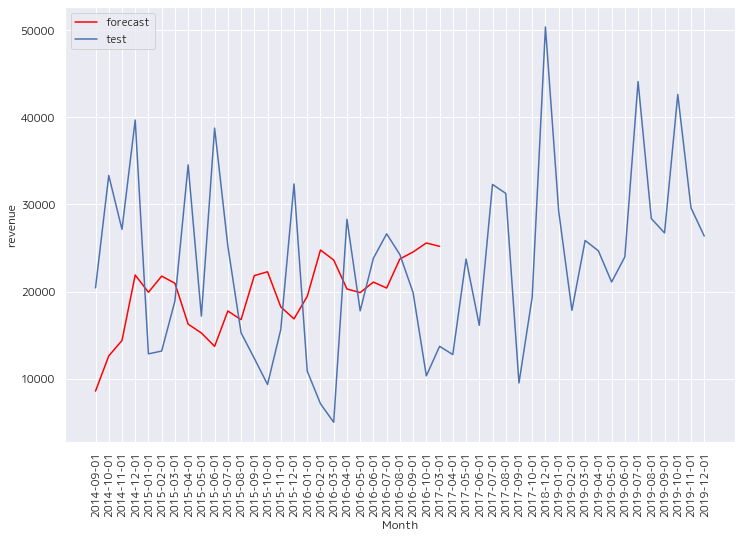

In [334]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][40:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[40:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [335]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

1314.5323994894927 [(0, 1, 1), (0, 1, 1, 12)]


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [69]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0135      4.889     -0.003      0.998      -9.596       9.569
ar.L2          0.1585      2.107      0.075      0.940      -3.970       4.287
ar.L3          0.3991      1.441      0.277      0.782      -2.426       3.224
ar.L4          0.3405      4.294      0.079      0.937      -8.076       8.757
ar.L5         -0.6783      3.095     -0.219      0.827      -6.745       5.388
ma.L1         -0.2973      3.072     -0.097      0.923      -6.318       5.723
ar.S.L12       0.3931      8.549      0.046      0.963     -16.362      17.149
ar.S.L24       0.8025      5.415      0.148      0.882      -9.811      11.416
ar.S.L36       0.2767      7.961      0.035      0.972     -15.326      15.879
ar.S.L48      -0.2594      1.334     -0.195      0.846      -2.873       2.354
ar.S.L60       0.1460      2.480      0.059      0.9

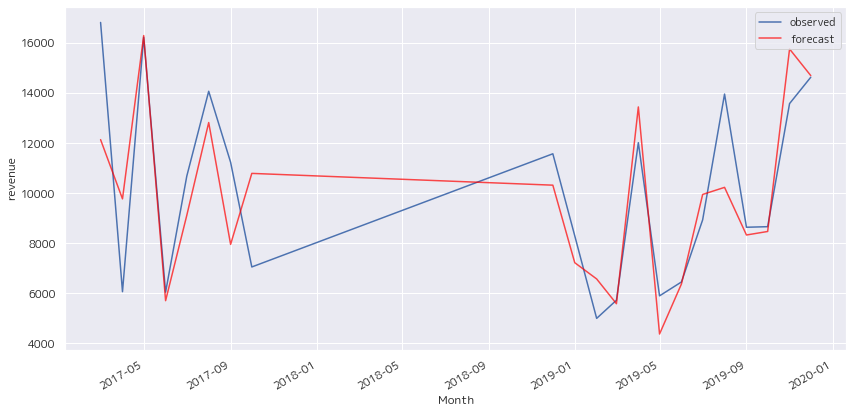

In [70]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [71]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 2113.888
MAPE: 0.171


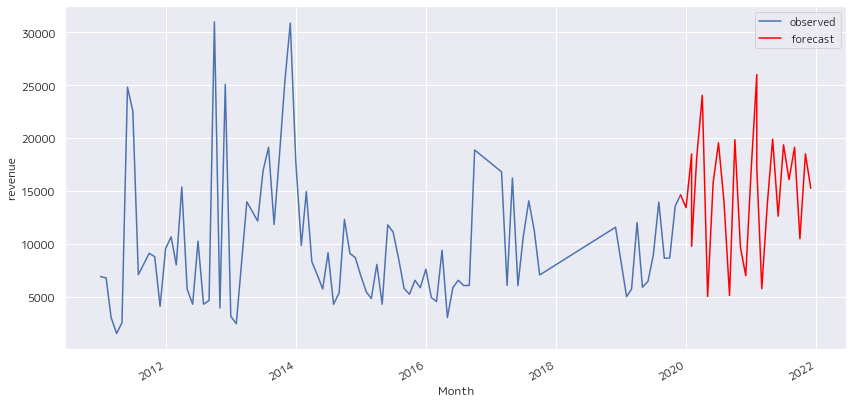

In [72]:
index = pd.to_datetime(['2019-12-01','2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_month[len(em_series_month)-1]
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [73]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,13417.162520
2020-02-01,18494.325902
2020-03-01,18202.984255
2020-02-01,9760.698253
2020-04-01,24045.220635
2020-05-01,5009.040362
2020-06-01,15788.187898
2020-07-01,19540.895417
2020-08-01,13954.787169
2020-09-01,5099.289642


In [74]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
#                                 order=(1, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7921      0.488      3.669      0.000       0.835       2.749
ar.S.L2       -0.5076      0.181     -2.809      0.005      -0.862      -0.153
ma.S.L2        3.7242      2.994      1.244      0.213      -2.143       9.592
sigma2      2.449e+09   1.59e-10   1.54e+19      0.000    2.45e+09    2.45e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


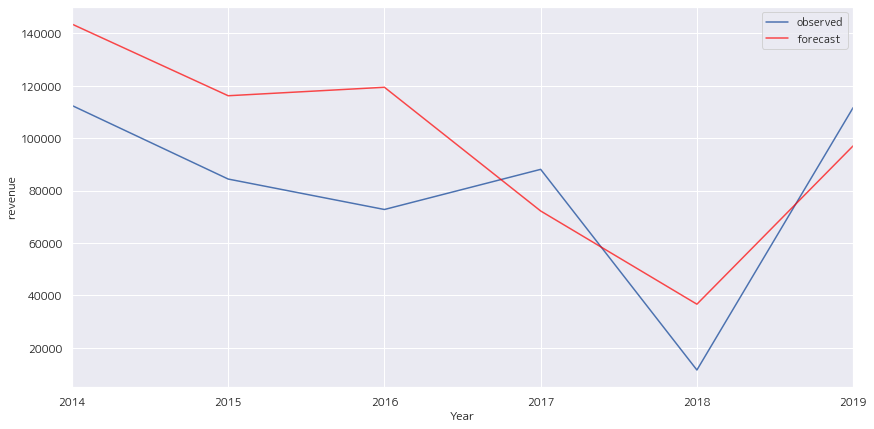

In [75]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [76]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 29557.317
MAPE: 0.629


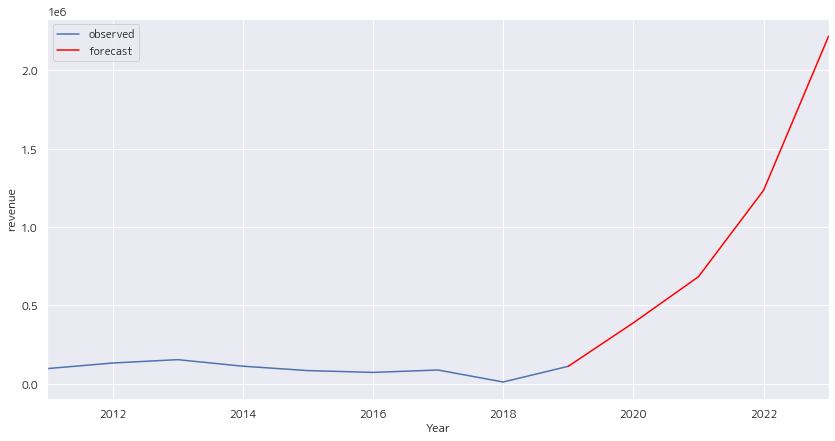

In [77]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_year[len(em_series_year)-1]
ax = em_series_year.plot(label='observed', figsize=(14, 7))
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [78]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,3.890107e+05
2021-01-01,6.831159e+05
2022-01-01,1.233878e+06
2023-01-01,2.218337e+06


# Engine Model L13A

In [90]:
df_sum_day = df_fp.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_fp.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_fp.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_fp.total_price.values,index=df_fp['Register Date'])

Text(0.5, 0, 'Month')

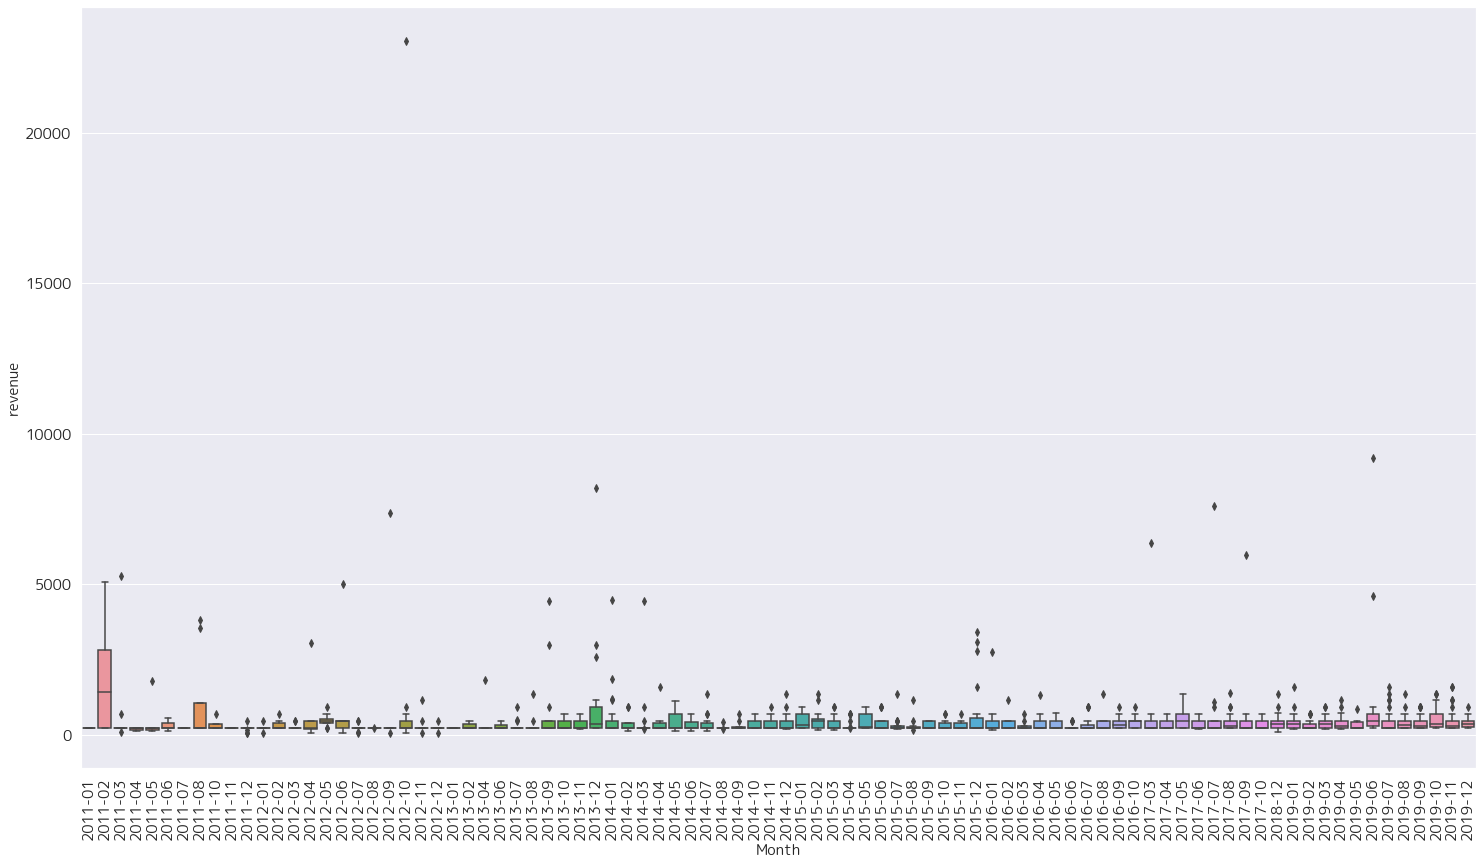

In [103]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

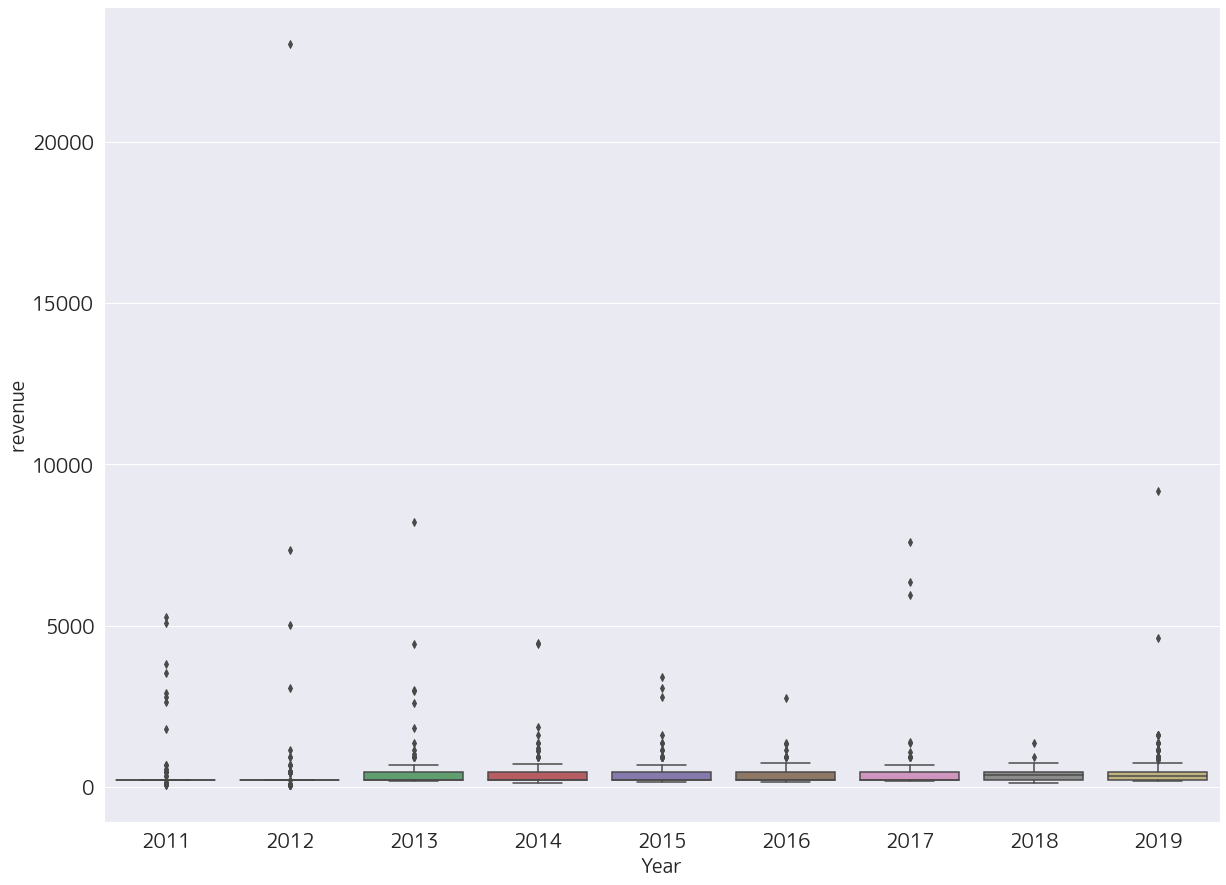

In [104]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

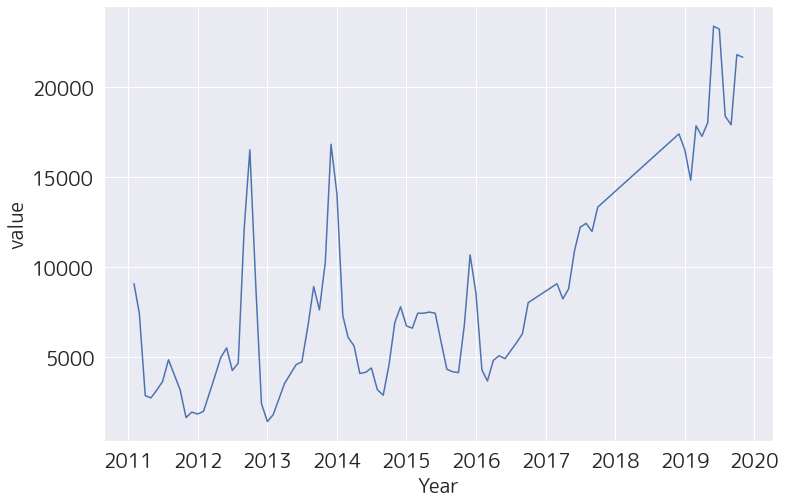

In [105]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [347]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=25285.821398, expected=8093.870000
predicted=15109.933865, expected=22646.390000
predicted=21633.801000, expected=32879.420000
predicted=25812.825692, expected=56744.130000
predicted=22470.761376, expected=46868.280000
predicted=25665.894124, expected=48773.980000
predicted=31097.053750, expected=47389.320000
predicted=36782.748406, expected=33592.290000
predicted=32470.688509, expected=21231.210000
predicted=26375.385282, expected=43776.670000
predicted=32640.362330, expected=45845.970000
predicted=33554.051527, expected=15566.640000
predicted=20324.420599, expected=30945.370000
predicted=26397.076465, expected=35733.890000
predicted=31237.793245, expected=20262.670000
predicted=20910.882638, expected=20813.750000
predicted=21954.550898, expected=39466.280000
predicted=28674.760070, expected=46124.760000
predicted=28368.721068, expected=15926.540000
predicted=20202.308835, expected=65221.450000
predicted=33507.482824, expected=59556.540000
predicted=38074.443693, expected=28

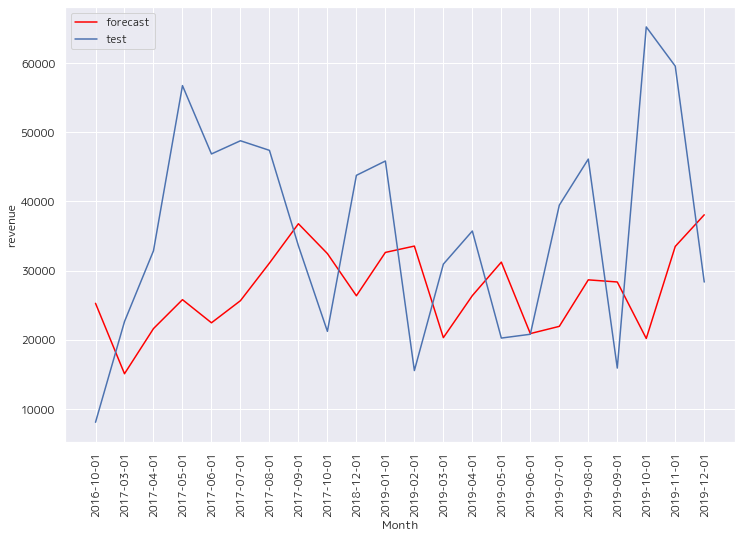

In [348]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [106]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 1),
                                seasonal_order=(5, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2402      1.622     -0.148      0.882      -3.419       2.939
ar.L2          0.2186      0.887      0.246      0.805      -1.519       1.956
ar.L3          0.5726      0.692      0.828      0.408      -0.783       1.929
ar.L4          0.7990      1.649      0.485      0.628      -2.433       4.030
ar.L5         -0.1135      1.793     -0.063      0.950      -3.629       3.402
ma.L1         -0.9115      1.435     -0.635      0.525      -3.723       1.900
ar.S.L12      -0.2329      1.254     -0.186      0.853      -2.690       2.225
ar.S.L24       0.8541      1.565      0.546      0.585      -2.212       3.920
ar.S.L36      -0.8354      0.983     -0.850      0.395      -2.763       1.092
ar.S.L48       0.8750      0.953      0.918      0.359      -0.994       2.744
ar.S.L60      -0.7481      0.955     -0.783      0.4

D:\Software\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


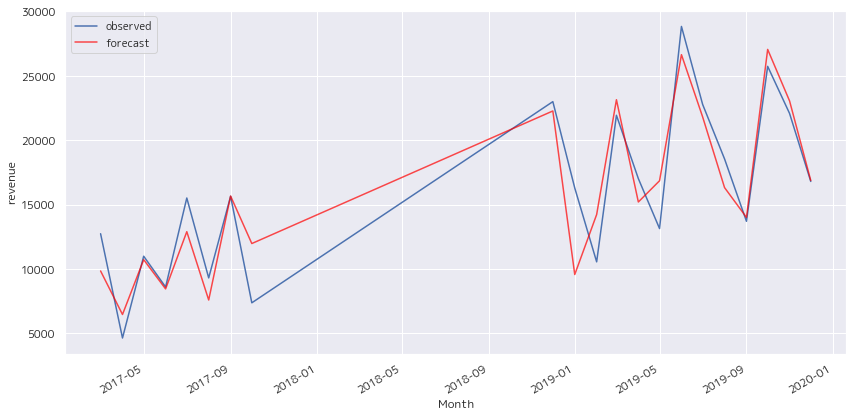

In [108]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [109]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 2526.124
MAPE: 0.154


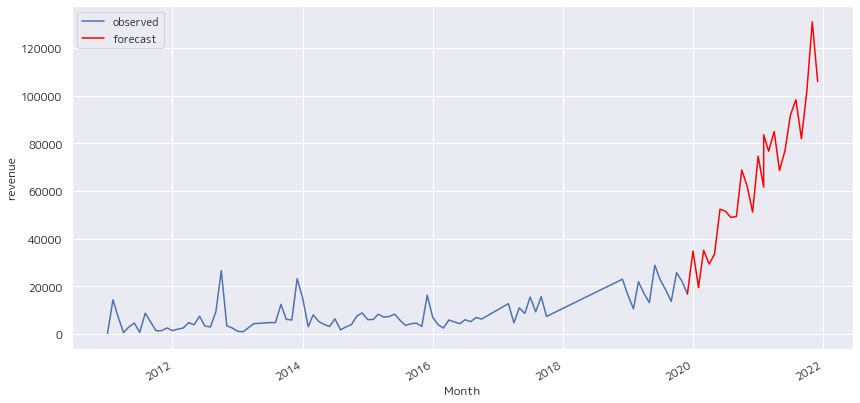

In [111]:
index = pd.to_datetime(['2019-12-01','2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_month[len(em_series_month)-1]
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [112]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,34785.084130
2020-02-01,19796.981718
2020-03-01,35149.740859
2020-02-01,19432.005467
2020-04-01,29329.916477
2020-05-01,33502.084851
2020-06-01,52388.376799
2020-07-01,51545.377965
2020-08-01,48895.110532
2020-09-01,49314.066518


In [113]:
mod =SARIMAX(em_series_year,
#                                 order=(1, 0, 1),
#                                 seasonal_order=(0, 0, 0, 12),
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1057      2.391      0.044      0.965      -4.581       4.793
ar.S.L2        1.4590      0.383      3.810      0.000       0.708       2.210
ma.S.L2       -1.3033      1.244     -1.047      0.295      -3.742       1.136
sigma2       6.02e+09   1.52e-11   3.95e+20      0.000    6.02e+09    6.02e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


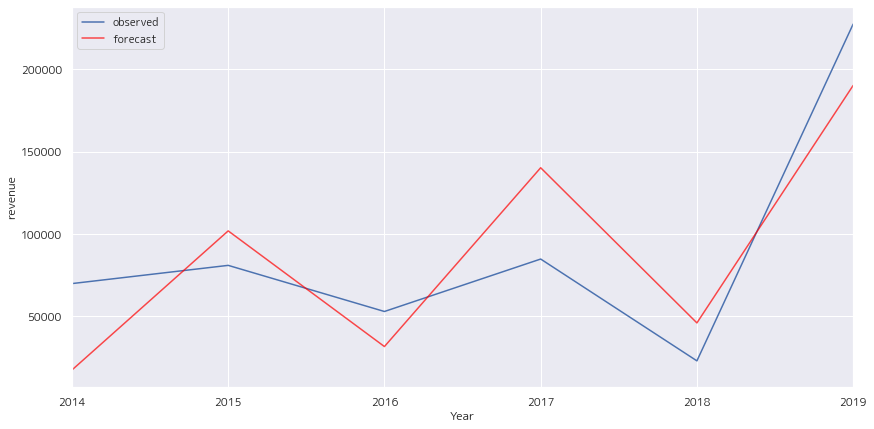

In [114]:
pred = results.get_prediction(start='2014-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2014-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [115]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2014-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 37919.327
MAPE: 0.538


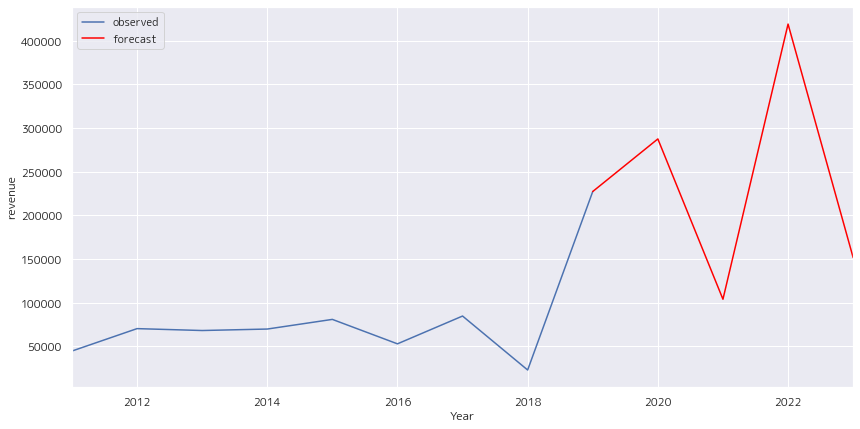

In [116]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
prediction = pred_uc.predicted_mean
prediction[0] = em_series_year[len(em_series_year)-1]
ax = em_series_year.plot(label='observed', figsize=(14, 7))
prediction.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [118]:
prediction.drop(prediction.index[0]).to_frame()

,predicted_mean
2020-01-01,287584.851065
2021-01-01,104027.522916
2022-01-01,419102.693753
2023-01-01,151727.518614


Text(0.5, 0, 'Month')

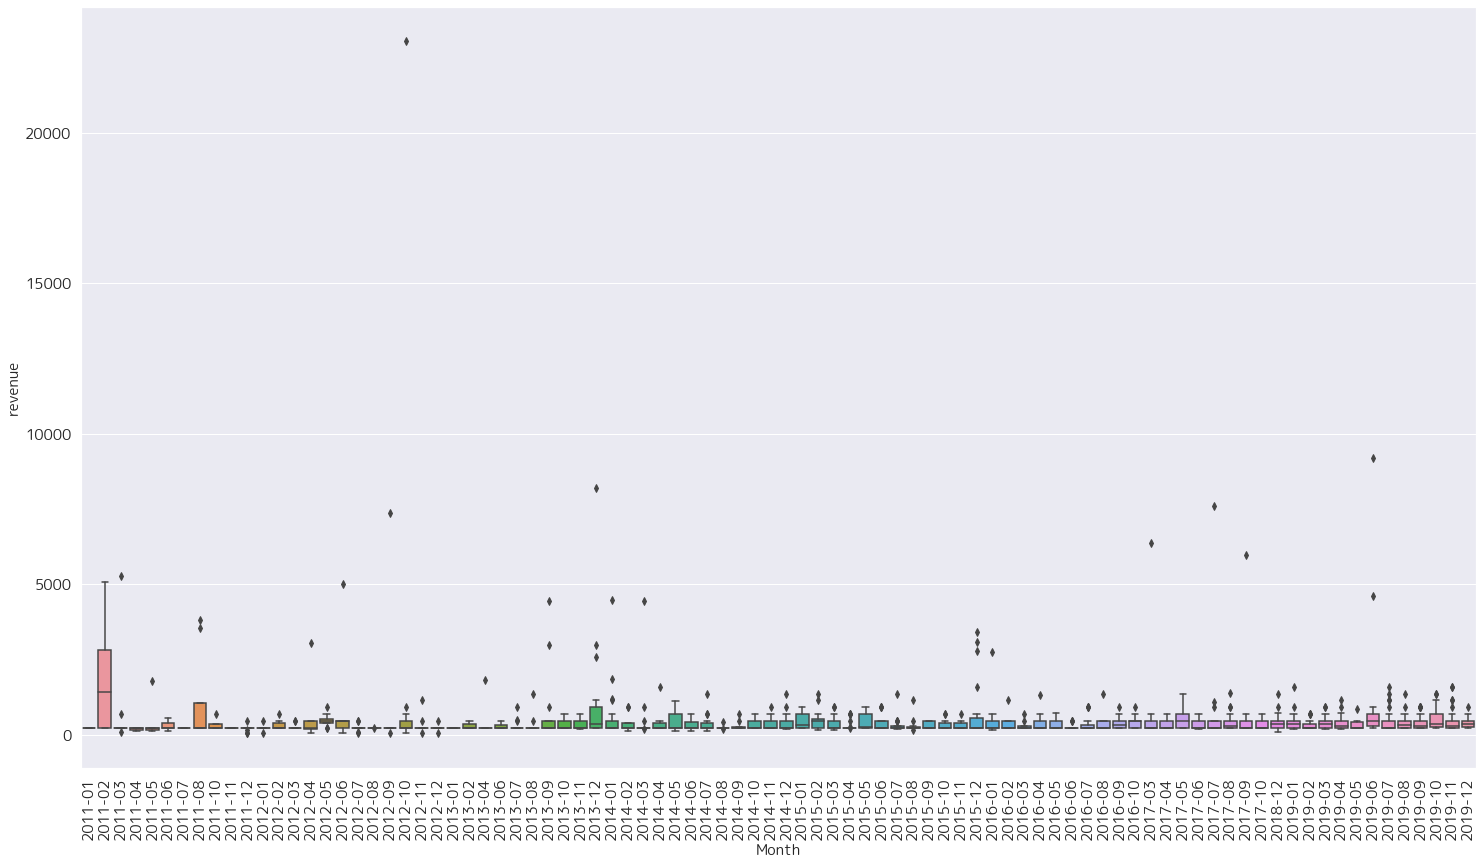

In [73]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

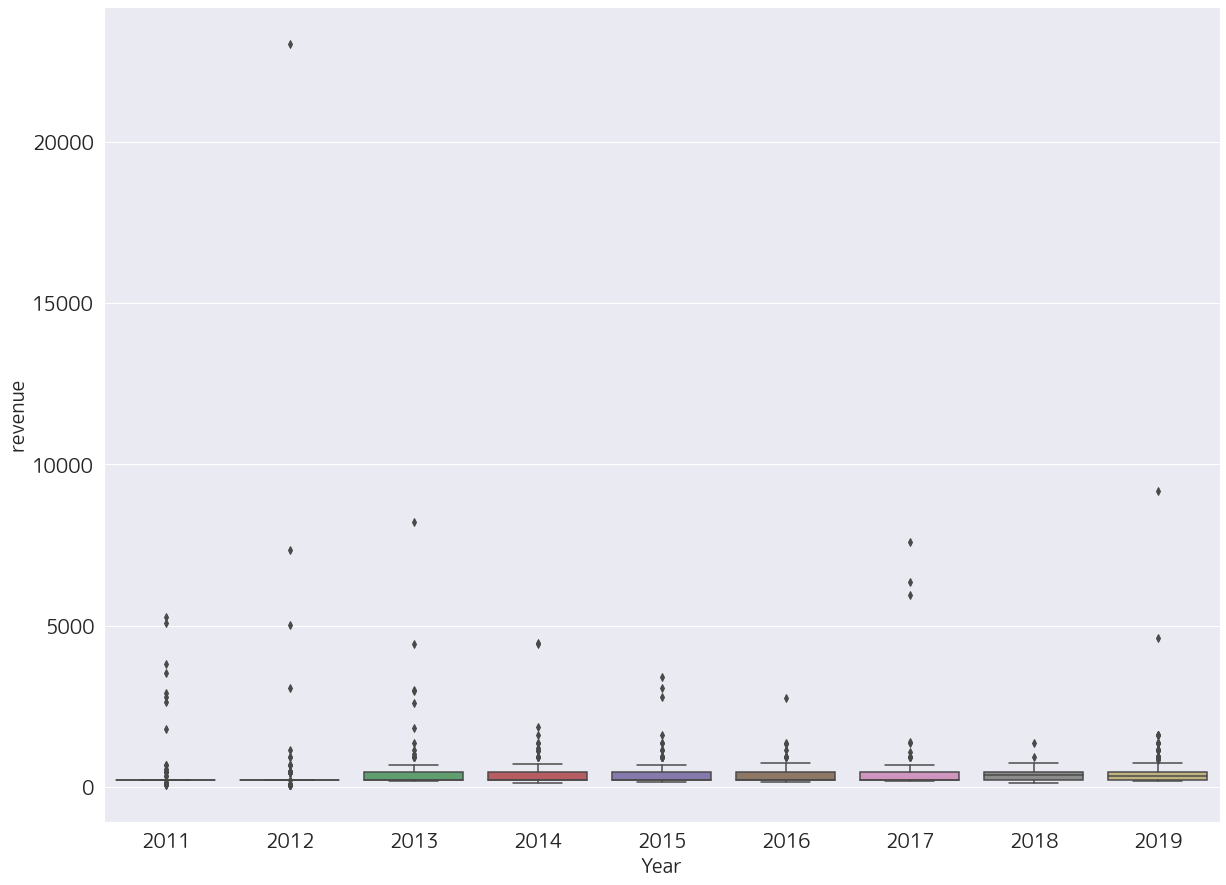

In [74]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)